# Анализ данных
Построим модели по предсказанию уровня доходов в стране по показателям производительности сети.

## Setup
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn import mixture

import seaborn as sns
from matplotlib import pyplot as plt

2023-05-26 03:42:22.921918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def check_folder(name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(name):
        os.makedirs(name)

    return name

In [3]:
DATA_TYPE = 'light'
SERIAL_TYPE = 'fixed'

SEED = 0  # to reproduce building
BATCH_SIZE = 64

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = f'data/{DATA_TYPE}'
LOGS_PATH = check_folder(f'logs/{DATA_TYPE}/{SERIAL_TYPE}')
MODEL_PATH = check_folder(f'model/{DATA_TYPE}/{SERIAL_TYPE}')
VISUAL_PATH = check_folder(f'visual/model/{DATA_TYPE}/{SERIAL_TYPE}')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

## Prepare
Загрузим датасет, отсортируем значения по годам и уровню доходов, уберём лишние признаки.

In [5]:
df = pd.read_csv(f'{DATA_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{DATA_TYPE}.csv').sort_values(by=['year', 'income'])
df.head()

,iso_a3,year,label,income,group,continent,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
728,VEN,2019,Venezuela,84.341,Low income,South America,2488.00,746.250,147.00000,433441,102768
756,ZWE,2019,Zimbabwe,369.445,Low income,Africa,7779.75,4636.625,26.50000,20461,7358
44,BDI,2019,Burundi,745.617,Low income,Africa,7248.50,7556.250,27.00000,2272,727
112,CAF,2019,Central African Republic,1005.373,Low income,Africa,1071.50,1191.875,401.58333,159,85
140,COD,2019,"Congo, Dem. Rep. of the",1112.838,Low income,Africa,4380.25,3332.000,97.50000,6622,2257


Сбалансируем датасет, приведя группы к единому размеру и сократив его до 200 000 наблюдений на группу:

In [6]:
# df = pd.concat([df_group[1].sample(n=50_000) for df_group in df.groupby(['group', 'year'], sort=False)])
df.groupby('group').describe().round(2).T

group              High income  Low income  Lower-middle income   
year       count  1.920000e+02      192.00               184.00  \
           mean   2.020500e+03     2020.50              2020.50   
           std    1.120000e+00        1.12                 1.12   
           min    2.019000e+03     2019.00              2019.00   
           25%    2.019750e+03     2019.75              2019.75   
           50%    2.020500e+03     2020.50              2020.50   
           75%    2.021250e+03     2021.25              2021.25   
           max    2.022000e+03     2022.00              2022.00   
income     count  1.920000e+02      192.00               184.00   
           mean   5.613182e+04     2607.53              9200.78   
           std    2.027840e+04     1215.84              2753.72   
           min    3.244392e+04       84.34              4790.26   
           25%    4.238231e+04     1565.36              6221.98   
           50%    5.168702e+04     2401.90              9426.28   
           75%    6.152785e+04     3633.70             11635.19   
           max    1.300029e+05     5124.90             13921.40   
avg_d_kbps count  1.920000e+02      192.00               184.00   
           mean   6.474286e+04     7731.85             13970.50   
           std    4.394808e+04     5499.20             10651.34   
           min    7.564120e+03     1071.50              2156.00   
           25%    3.098642e+04     4003.09              7096.75   
           50%    5.374375e+04     6101.00             10047.04   
           75%    8.633458e+04     9536.72             17283.88   
           max    2.479582e+05    30473.00             67096.50   
avg_u_kbps count  1.920000e+02      192.00               184.00   
           mean   3.645767e+04     4963.32              9829.41   
           std    4.052508e+04     4839.06             11009.07   
           min    2.303250e+03      282.00               589.38   
           25%    1.057417e+04     2485.50              2798.75   
           50%    1.775888e+04     3899.88              5702.00   
           75%    4.896506e+04     5424.99             11679.56   
           max    2.153611e+05    30707.12             53607.88   
avg_lat_ms count  1.920000e+02      192.00               184.00   
           mean   1.551000e+01      101.00                30.64   
           std    7.680000e+00      181.65                30.30   
           min    4.000000e+00        6.75                 4.50   
           25%    9.500000e+00       24.88                15.94   
           50%    1.500000e+01       35.25                23.69   
           75%    2.000000e+01       69.94                36.00   
           max    5.267000e+01      819.00               214.33   
tests      count  1.920000e+02      192.00               184.00   
           mean   4.977930e+06    94195.38           2665961.07   
           std    1.319053e+07   319500.45           7379768.44   
           min    7.031000e+03       12.00                41.00   
           25%    3.527465e+05     2370.75             25932.00   
           50%    1.386396e+06     7993.00            356269.50   
           75%    3.580494e+06    29365.00           1397706.00   
           max    1.065139e+08  2660579.00          50792050.00   
devices    count  1.920000e+02      192.00               184.00   
           mean   1.410463e+06    22763.71            632038.15   
           std    3.821268e+06    69225.49           1620824.04   
           min    2.718000e+03        5.00                21.00   
           25%    1.114872e+05      680.25              8703.00   
           50%    3.900095e+05     2542.50             87665.50   
           75%    1.033388e+06     7961.75            350170.00   
           max    2.936323e+07   512465.00          11179184.00   

group             Upper-middle income  
year       count               192.00  
           mean               2020.50  
           std                   1.12  
           min      

Категоризируем целевой признак `group`:

In [7]:
values, groups = pd.factorize(df.pop('group'))
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(groups)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Категоризируем качественный признак `continent` и переведём его в dummy-переменную:

In [8]:
values, continents = pd.factorize(df.pop('continent'))
df = pd.concat([df, pd.DataFrame(tf.keras.utils.to_categorical(values, dtype='int8'), index=df.index, columns=continents)], axis=1)

print('\n'.join(f'{n} - {v}' for n, v in enumerate(continents)))

0 - South America
1 - Africa
2 - Oceania
3 - Asia
4 - North America
5 - Europe
6 - Seven seas (open ocean)


Уберём лишние колонки и перетасуем полученный датасет:

In [9]:
df = df.drop(columns=['iso_a3', 'label', 'income']).sample(frac=1)
df.head()

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
522,2021,40184.250000,16153.25,19.0,1026774,299887,3,0,0,1,0,0,0,0
657,2020,11275.750000,2964.25,30.5,85302,16914,0,0,1,0,0,0,0,0
35,2022,48115.166667,12609.25,25.0,6564437,2033066,3,0,0,1,0,0,0,0
76,2019,9701.000000,1657.75,20.0,333813,108459,2,0,0,0,0,0,1,0
324,2019,49708.500000,45173.50,9.5,63473,30735,3,0,0,0,0,0,1,0


Построим корреляционную матрицу и посмотрим, насколько связаны полученные признаки:

In [10]:
df_corr = df.corr(method='spearman').round(2)
df_corr

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
year,1.00,0.25,0.22,-0.23,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avg_d_kbps,0.25,1.00,0.86,-0.79,0.50,0.52,0.72,-0.08,-0.52,-0.18,0.15,0.15,0.44,0.01
avg_u_kbps,0.22,0.86,1.00,-0.80,0.40,0.42,0.54,-0.06,-0.45,-0.18,0.23,0.02,0.36,0.05
avg_lat_ms,-0.23,-0.79,-0.80,1.00,-0.36,-0.38,-0.51,0.03,0.45,0.27,-0.19,-0.07,-0.37,-0.16
tests,0.05,0.50,0.40,-0.36,1.00,1.00,0.58,0.18,-0.47,-0.32,0.28,0.02,0.31,-0.08
devices,0.04,0.52,0.42,-0.38,1.00,1.00,0.59,0.17,-0.48,-0.32,0.29,0.02,0.33,-0.07
group,0.00,0.72,0.54,-0.51,0.58,0.59,1.00,-0.02,-0.57,-0.17,0.12,0.10,0.51,0.05
South America,0.00,-0.08,-0.06,0.03,0.18,0.17,-0.02,1.00,-0.16,-0.07,-0.14,-0.10,-0.14,-0.03
Africa,0.00,-0.52,-0.45,0.45,-0.47,-0.48,-0.57,-0.16,1.00,-0.17,-0.34,-0.23,-0.32,-0.08
Oceania,0.00,-0.18,-0.18,0.27,-0.32,-0.32,-0.17,-0.07,-0.17,1.00,-0.16,-0.11,-0.15,-0.04


Выведем данную матрицу на тепловую карту:

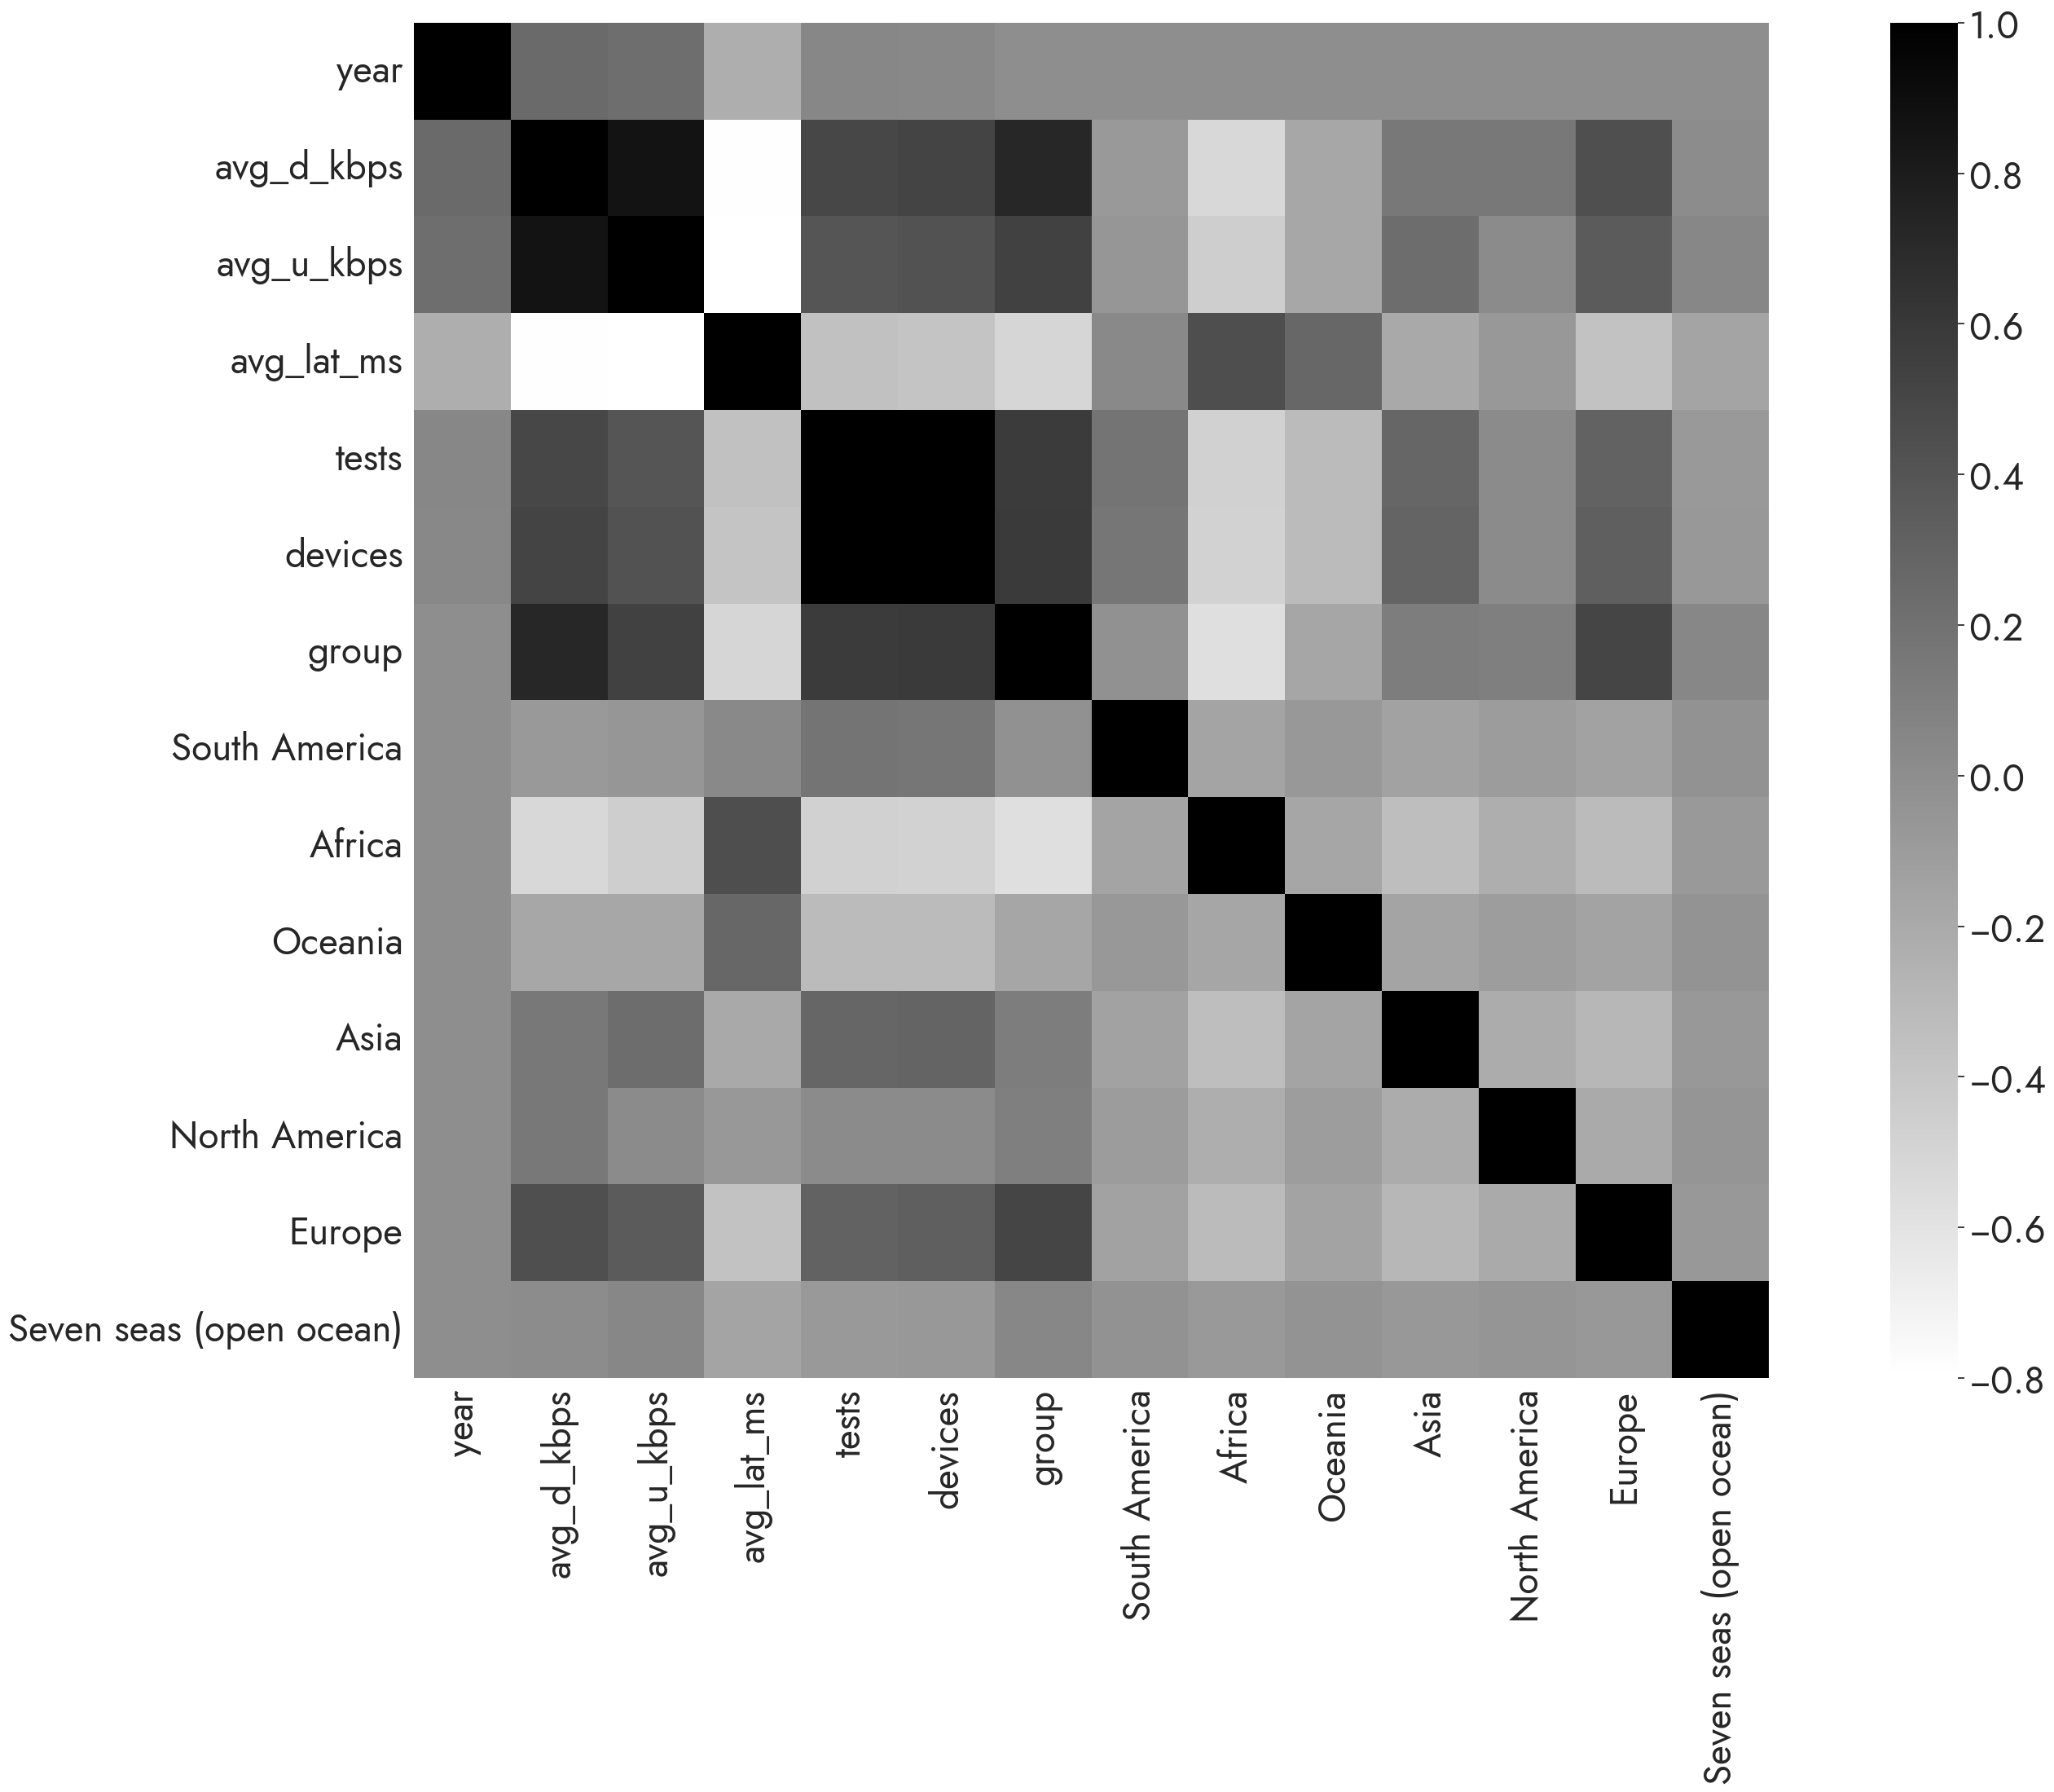

In [11]:
df_plot_corr = sns.heatmap(df_corr, cmap='gray_r', square=True);

In [12]:
df_plot_corr.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_corr.png', transparent=True)

Разделим датасет на обучающий набор - 80%, и на тестовый - 20%:

In [13]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(f'{len(train_df)} training examples')
print(f'{len(test_df)} training examples')

608 training examples
152 training examples


Выделим целевой признак и преобразуем его в бинарную dummy-переменную.

In [14]:
train_features = train_df.copy()
train_target = tf.keras.utils.to_categorical(train_features.pop('group'), dtype='int8')

In [15]:
test_features = test_df.copy()
test_target = tf.keras.utils.to_categorical(test_features.pop('group'), dtype='int8')

Из ноутбука с визуализацией было выяснено, что признаки имеют выраженное левостороннее распределение.
Создадим слой для их нормализации:

In [16]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE)

2023-05-26 03:42:40.544680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 03:42:40.565413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 03:42:40.565482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 03:42:40.567353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 03:42:40.567471: I tensorflow/compile

## Classic
Построим модель с применением метода ближайших соседей.

Данный метод не предполагает обработку dummy-переменных. Вернём результирующий показатель в исходный вид:

In [17]:
classic_train_target = train_df['group']
classic_test_target = test_df['group']

Создадим модель и обучим её на примерах тренировочного набора:

In [18]:
classic_model = sklearn.neighbors.KNeighborsClassifier()
classic_model.fit(train_features, classic_train_target);

Посмотрим предсказательные возможности модели.

In [19]:
classic_model.score(train_features, classic_train_target)

0.6611842105263158

In [20]:
classic_model.score(test_features, classic_test_target)

0.5526315789473685

Таким образом, предсказательная точность алгоритмической модели достаточно низкая.

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [21]:
classic_test_predict = pd.Series(classic_model.predict(test_features), index=test_df.index)

Рассмотрим распределение предсказаний модели по группам:

In [22]:
classic_dist = sklearn.metrics.confusion_matrix(classic_test_target, classic_test_predict)
classic_dist

array([[31,  4,  3,  0],
       [ 7, 15,  7,  4],
       [ 5,  9, 17, 11],
       [ 0,  7, 11, 21]])

Выведем данную таблицу на тепловую карту:

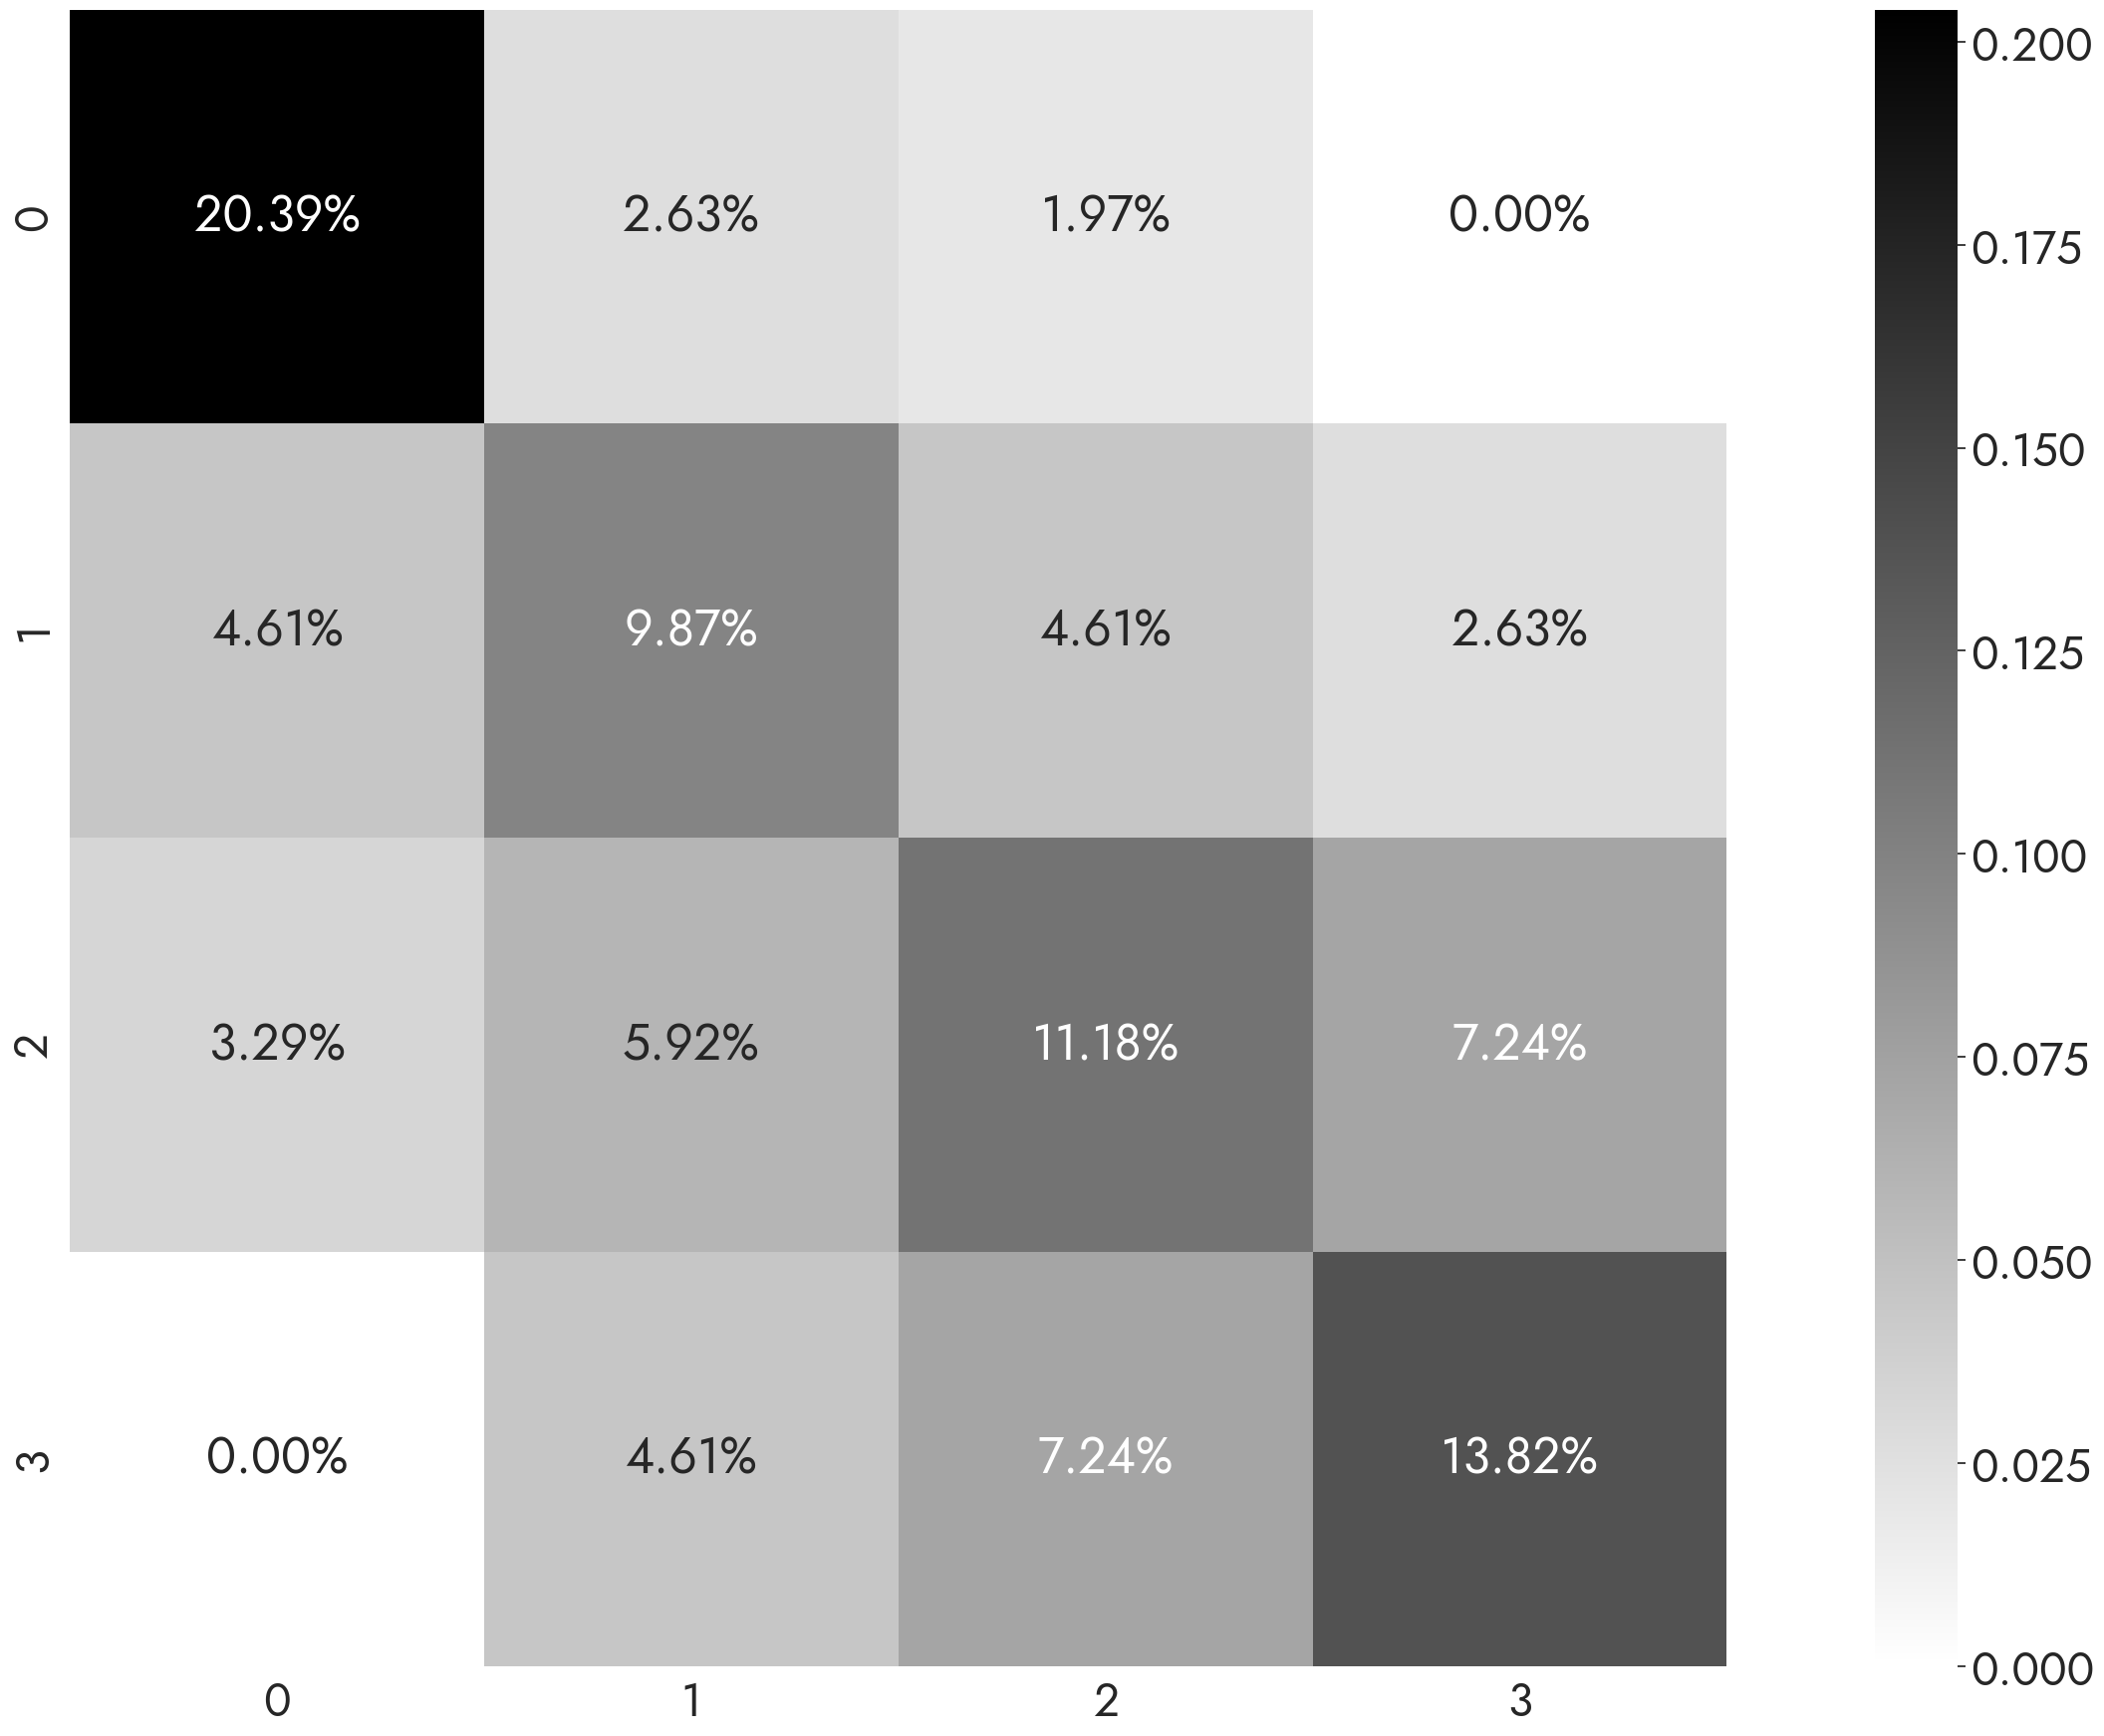

In [23]:
classic_plot_dist = sns.heatmap(classic_dist / classic_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

classic_plot_dist.set_xlabel(None);

In [24]:
classic_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_classic_dist.png', transparent=True)

Как видно по сводной таблице и по графику, модель в большинстве случаев неверно определяет группу.
Визуализируем распределение ошибок в модели:

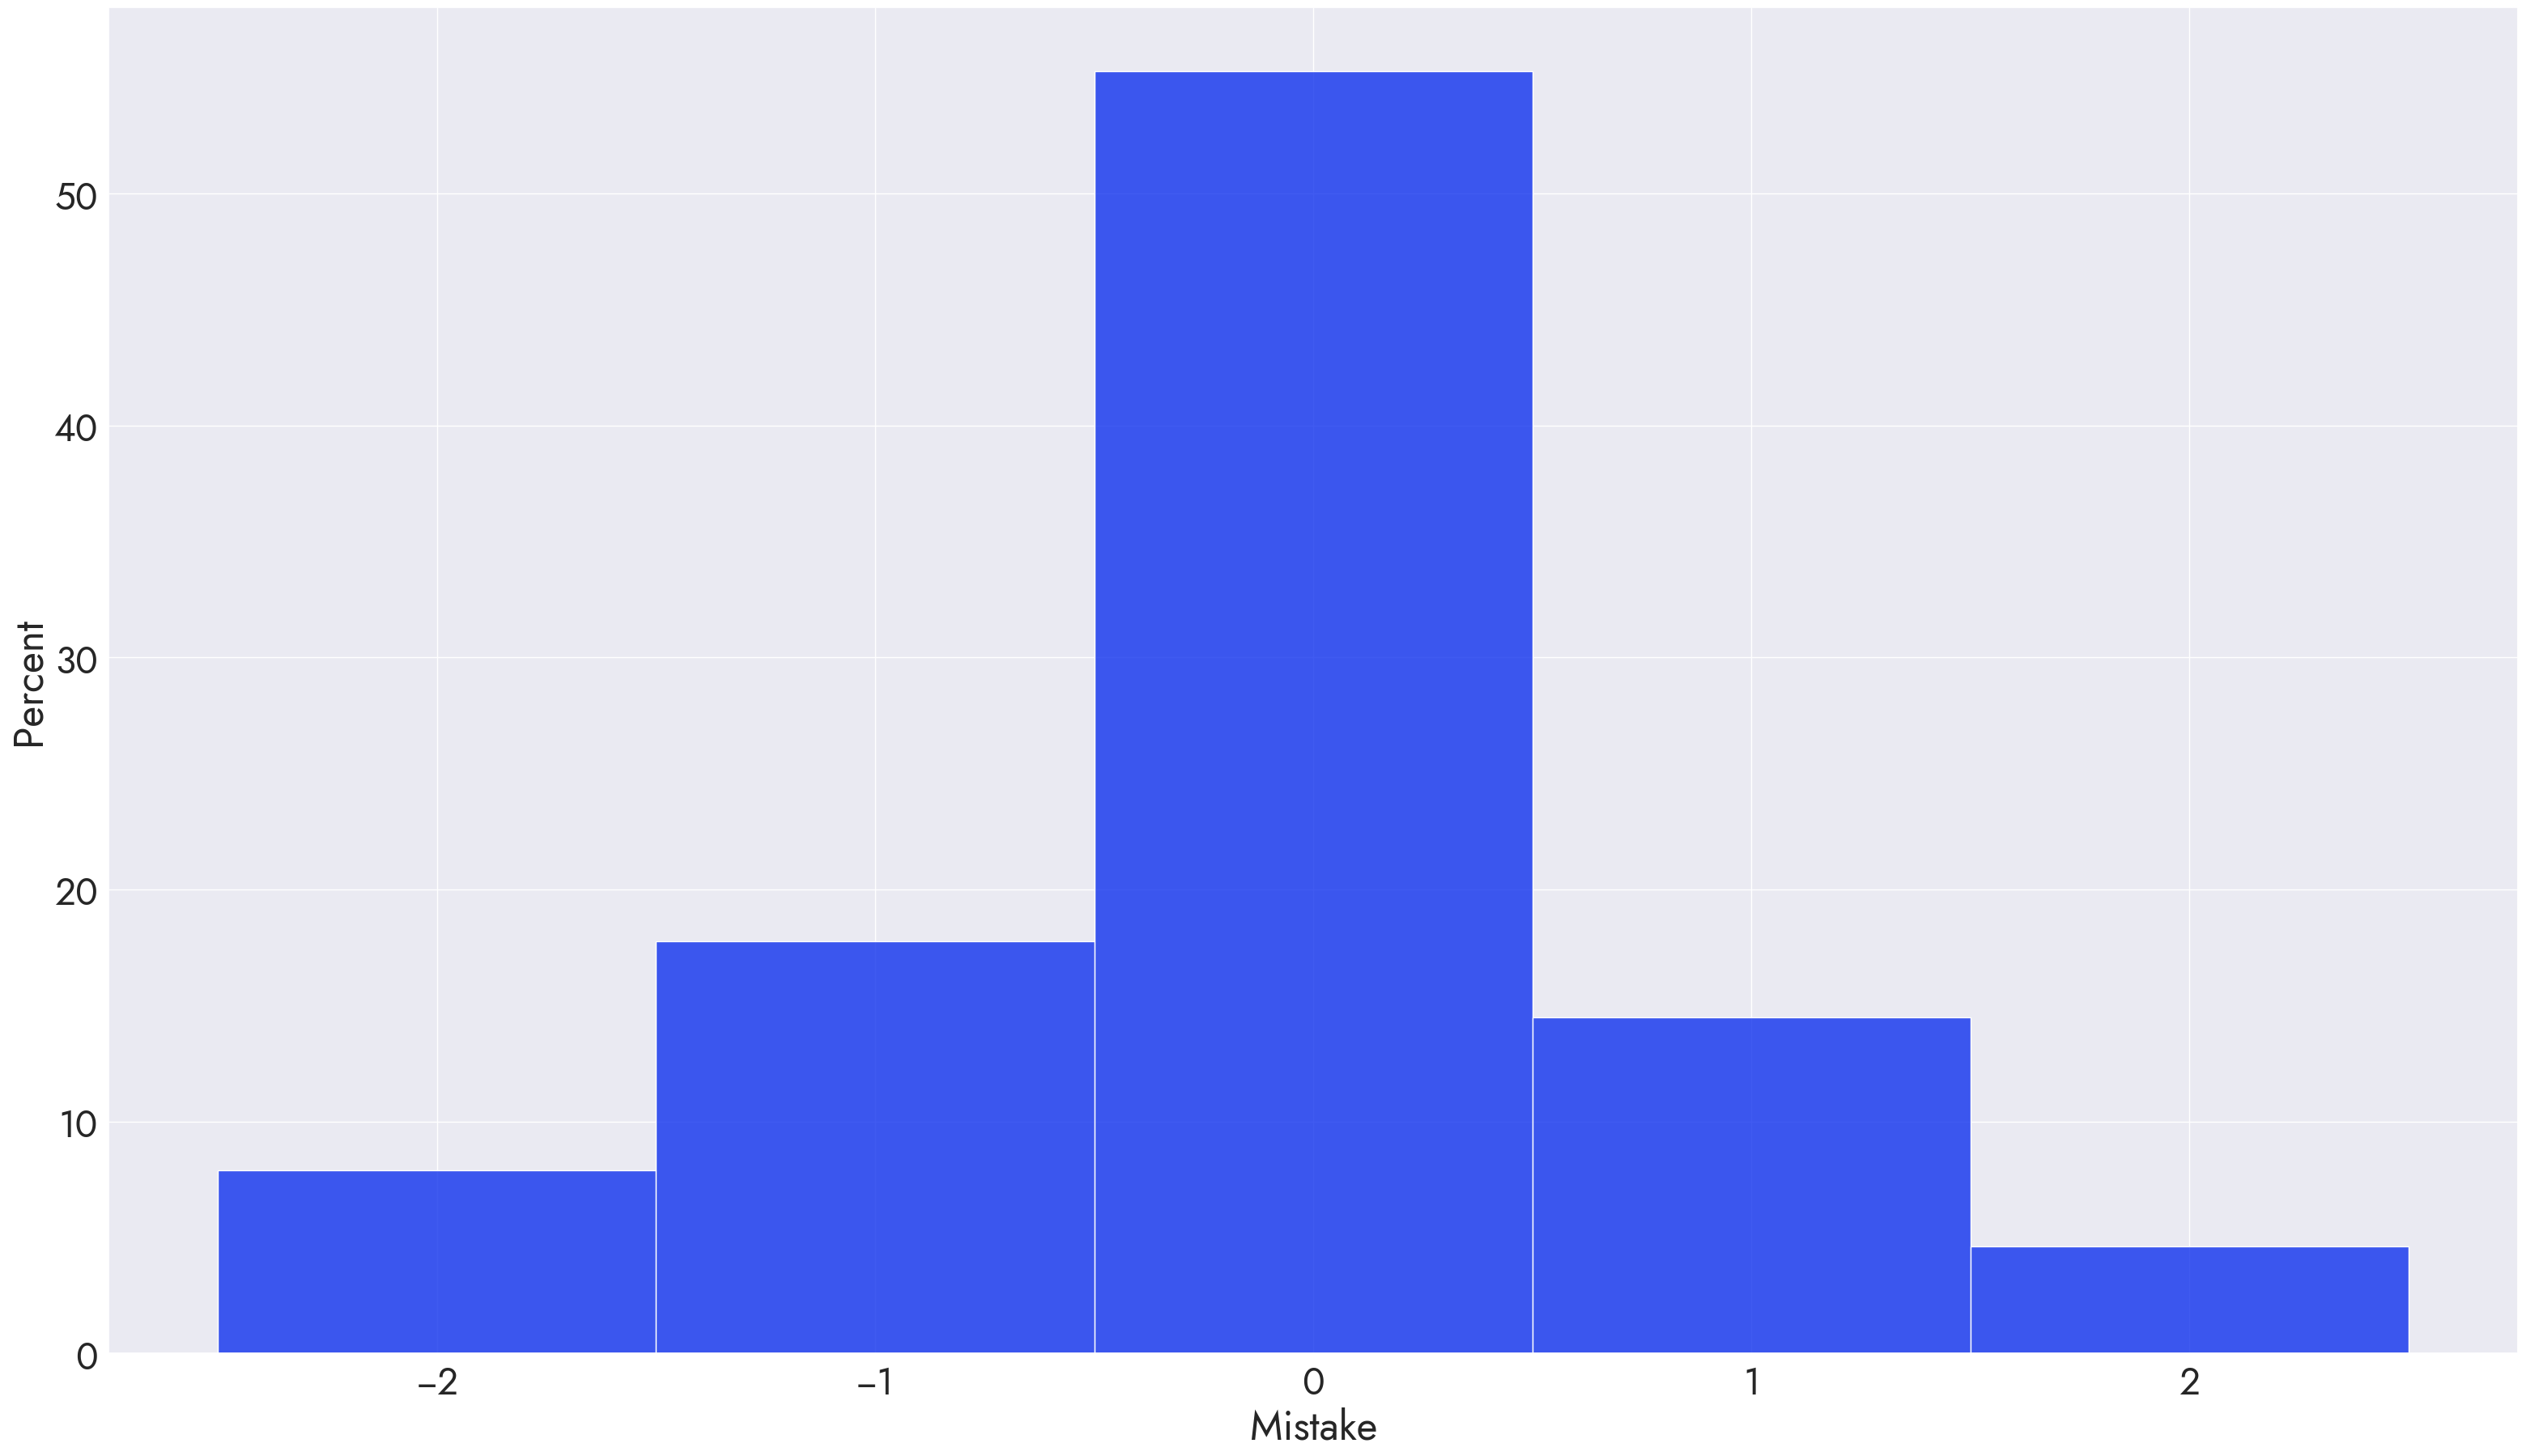

In [25]:
classic_plot_mistakes = sns.histplot(data=classic_test_predict - classic_test_target,
                                     stat='percent', legend=False, discrete=True)

classic_plot_mistakes.set_xlabel('Mistake');

In [26]:
classic_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_classic_mistakes.png', transparent=True)

Распределение имеет околонормальный вид - но, тем не менее, ошибок достаточно большое количество.

## Setting
В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [27]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 1000):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # number model loops
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=10),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{SERIAL_TYPE}_{model.name}'),
        ],
    )

    return history.history

## Deep neural networks
Построим модели глубоких нейронных сетей (DNN).

Создадим переменную, в которой будут сохраниться логи обучения моделей:

In [28]:
size_histories = {}

### tiny
Обучим модель, состоящую из двух обучающих слоёв.

In [29]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='tiny'
)

In [30]:
size_histories['tiny'] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 319
Trainable params: 292
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000


2023-05-26 03:44:42.794187: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa758378700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-26 03:44:42.794233: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-26 03:44:42.799008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-26 03:44:44.337103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-26 03:44:44.460816: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-26 03:44:44.534680: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 - 4s - loss: 1.8408 - accuracy: 0.1440 - val_loss: 1.7104 - val_accuracy: 0.1311 - 4s/epoch - 453ms/step
Epoch 2/1000
8/8 - 0s - loss: 1.7538 - accuracy: 0.1502 - val_loss: 1.6432 - val_accuracy: 0.1721 - 90ms/epoch - 11ms/step
Epoch 3/1000
8/8 - 0s - loss: 1.6791 - accuracy: 0.1687 - val_loss: 1.5821 - val_accuracy: 0.1885 - 95ms/epoch - 12ms/step
Epoch 4/1000
8/8 - 0s - loss: 1.6137 - accuracy: 0.1770 - val_loss: 1.5301 - val_accuracy: 0.2131 - 97ms/epoch - 12ms/step
Epoch 5/1000
8/8 - 0s - loss: 1.5548 - accuracy: 0.2037 - val_loss: 1.4835 - val_accuracy: 0.2295 - 92ms/epoch - 12ms/step
Epoch 6/1000
8/8 - 0s - loss: 1.5024 - accuracy: 0.2243 - val_loss: 1.4424 - val_accuracy: 0.2623 - 99ms/epoch - 12ms/step
Epoch 7/1000
8/8 - 0s - loss: 1.4568 - accuracy: 0.3107 - val_loss: 1.4050 - val_accuracy: 0.3607 - 96ms/epoch - 12ms/step
Epoch 8/1000
8/8 - 0s - loss: 1.4152 - accuracy: 0.4053 - val_loss: 1.3717 - val_accuracy: 0.4098 - 86ms/epoch - 11ms/step
Epoch 9/1000
8/8 - 0s - loss: 

Визуализируем ход обучения:

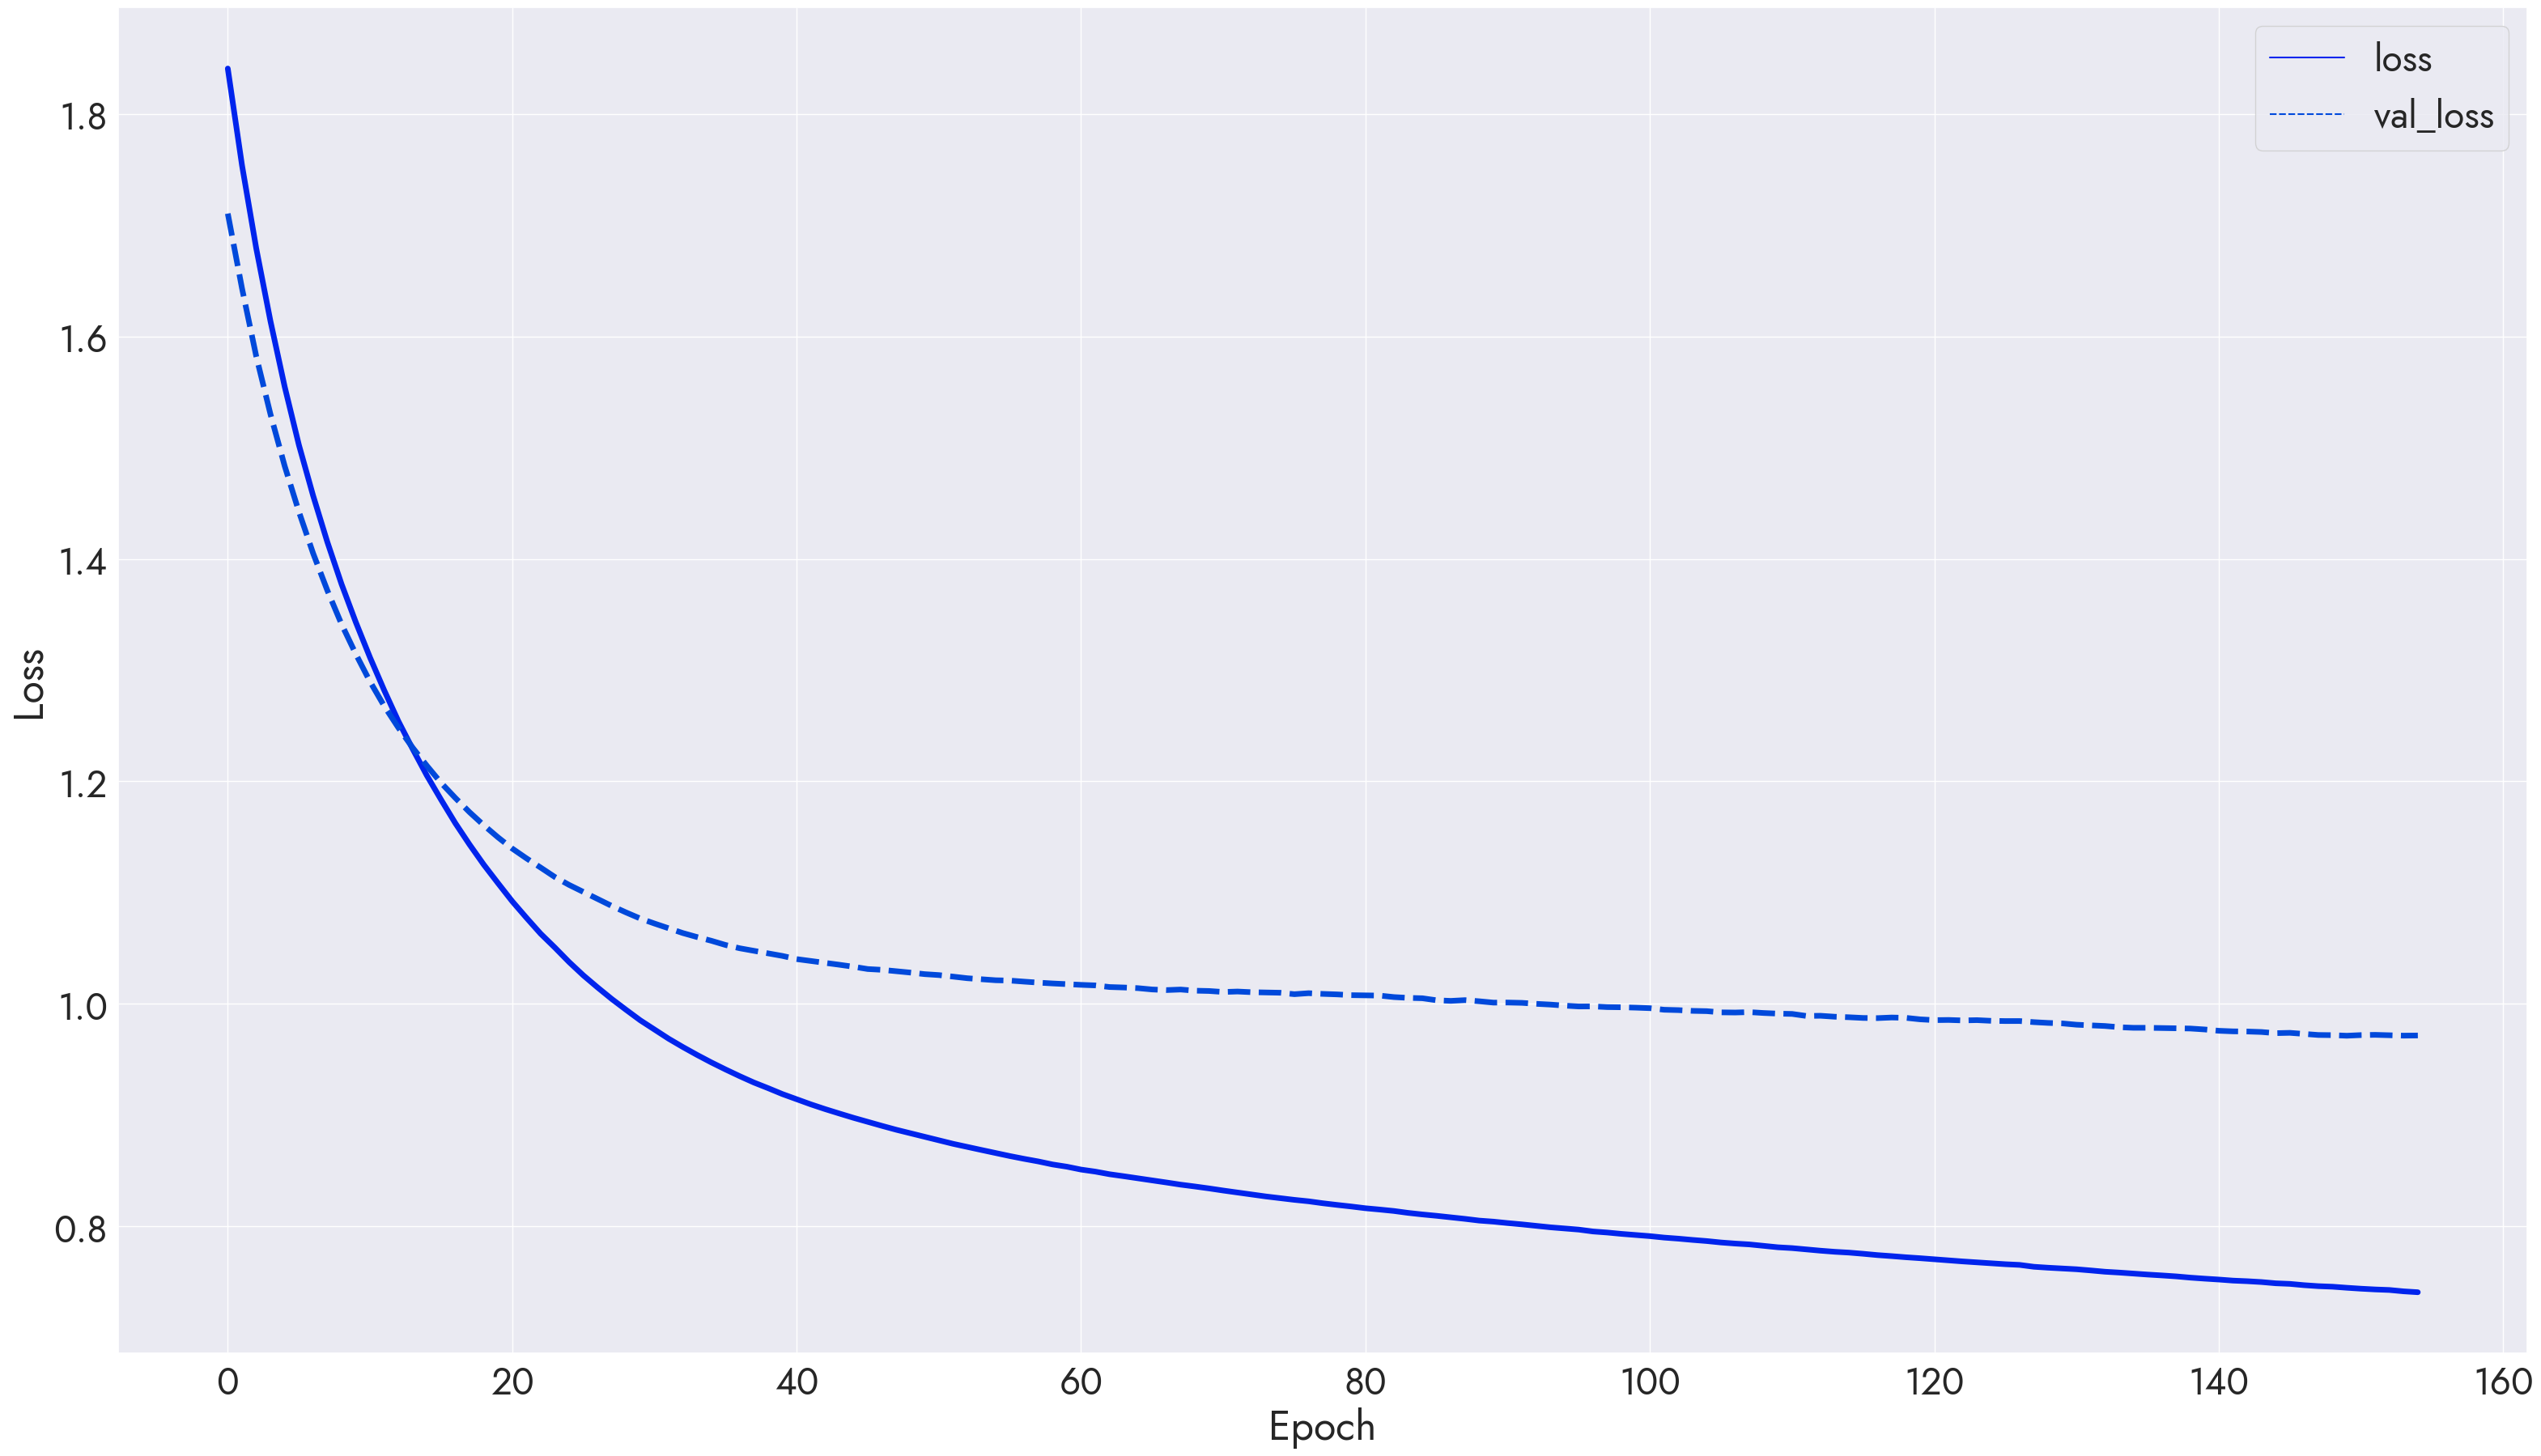

In [31]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['tiny'])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('Epoch')
tiny_plot_history.set_ylabel('Loss');

In [32]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{tiny_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [33]:
tiny_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

10/10 - 0s - loss: 0.7865 - accuracy: 0.6809 - 71ms/epoch - 7ms/step


In [34]:
tiny_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

3/3 - 0s - loss: 0.7530 - accuracy: 0.6447 - 38ms/epoch - 13ms/step


Сохраним обученную модель:

In [35]:
tiny_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{tiny_model.name}')

INFO:tensorflow:Assets written to: model/light/fixed/fixed/fixed_tiny/assets


### small
Обучим модель, состоящую из трёх обучающих слоёв.

In [36]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='small'
)

In [37]:
size_histories['small'] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                224       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 591
Trainable params: 564
Non-trainable params: 27
______________________________________________________________

Визуализируем ход обучения:

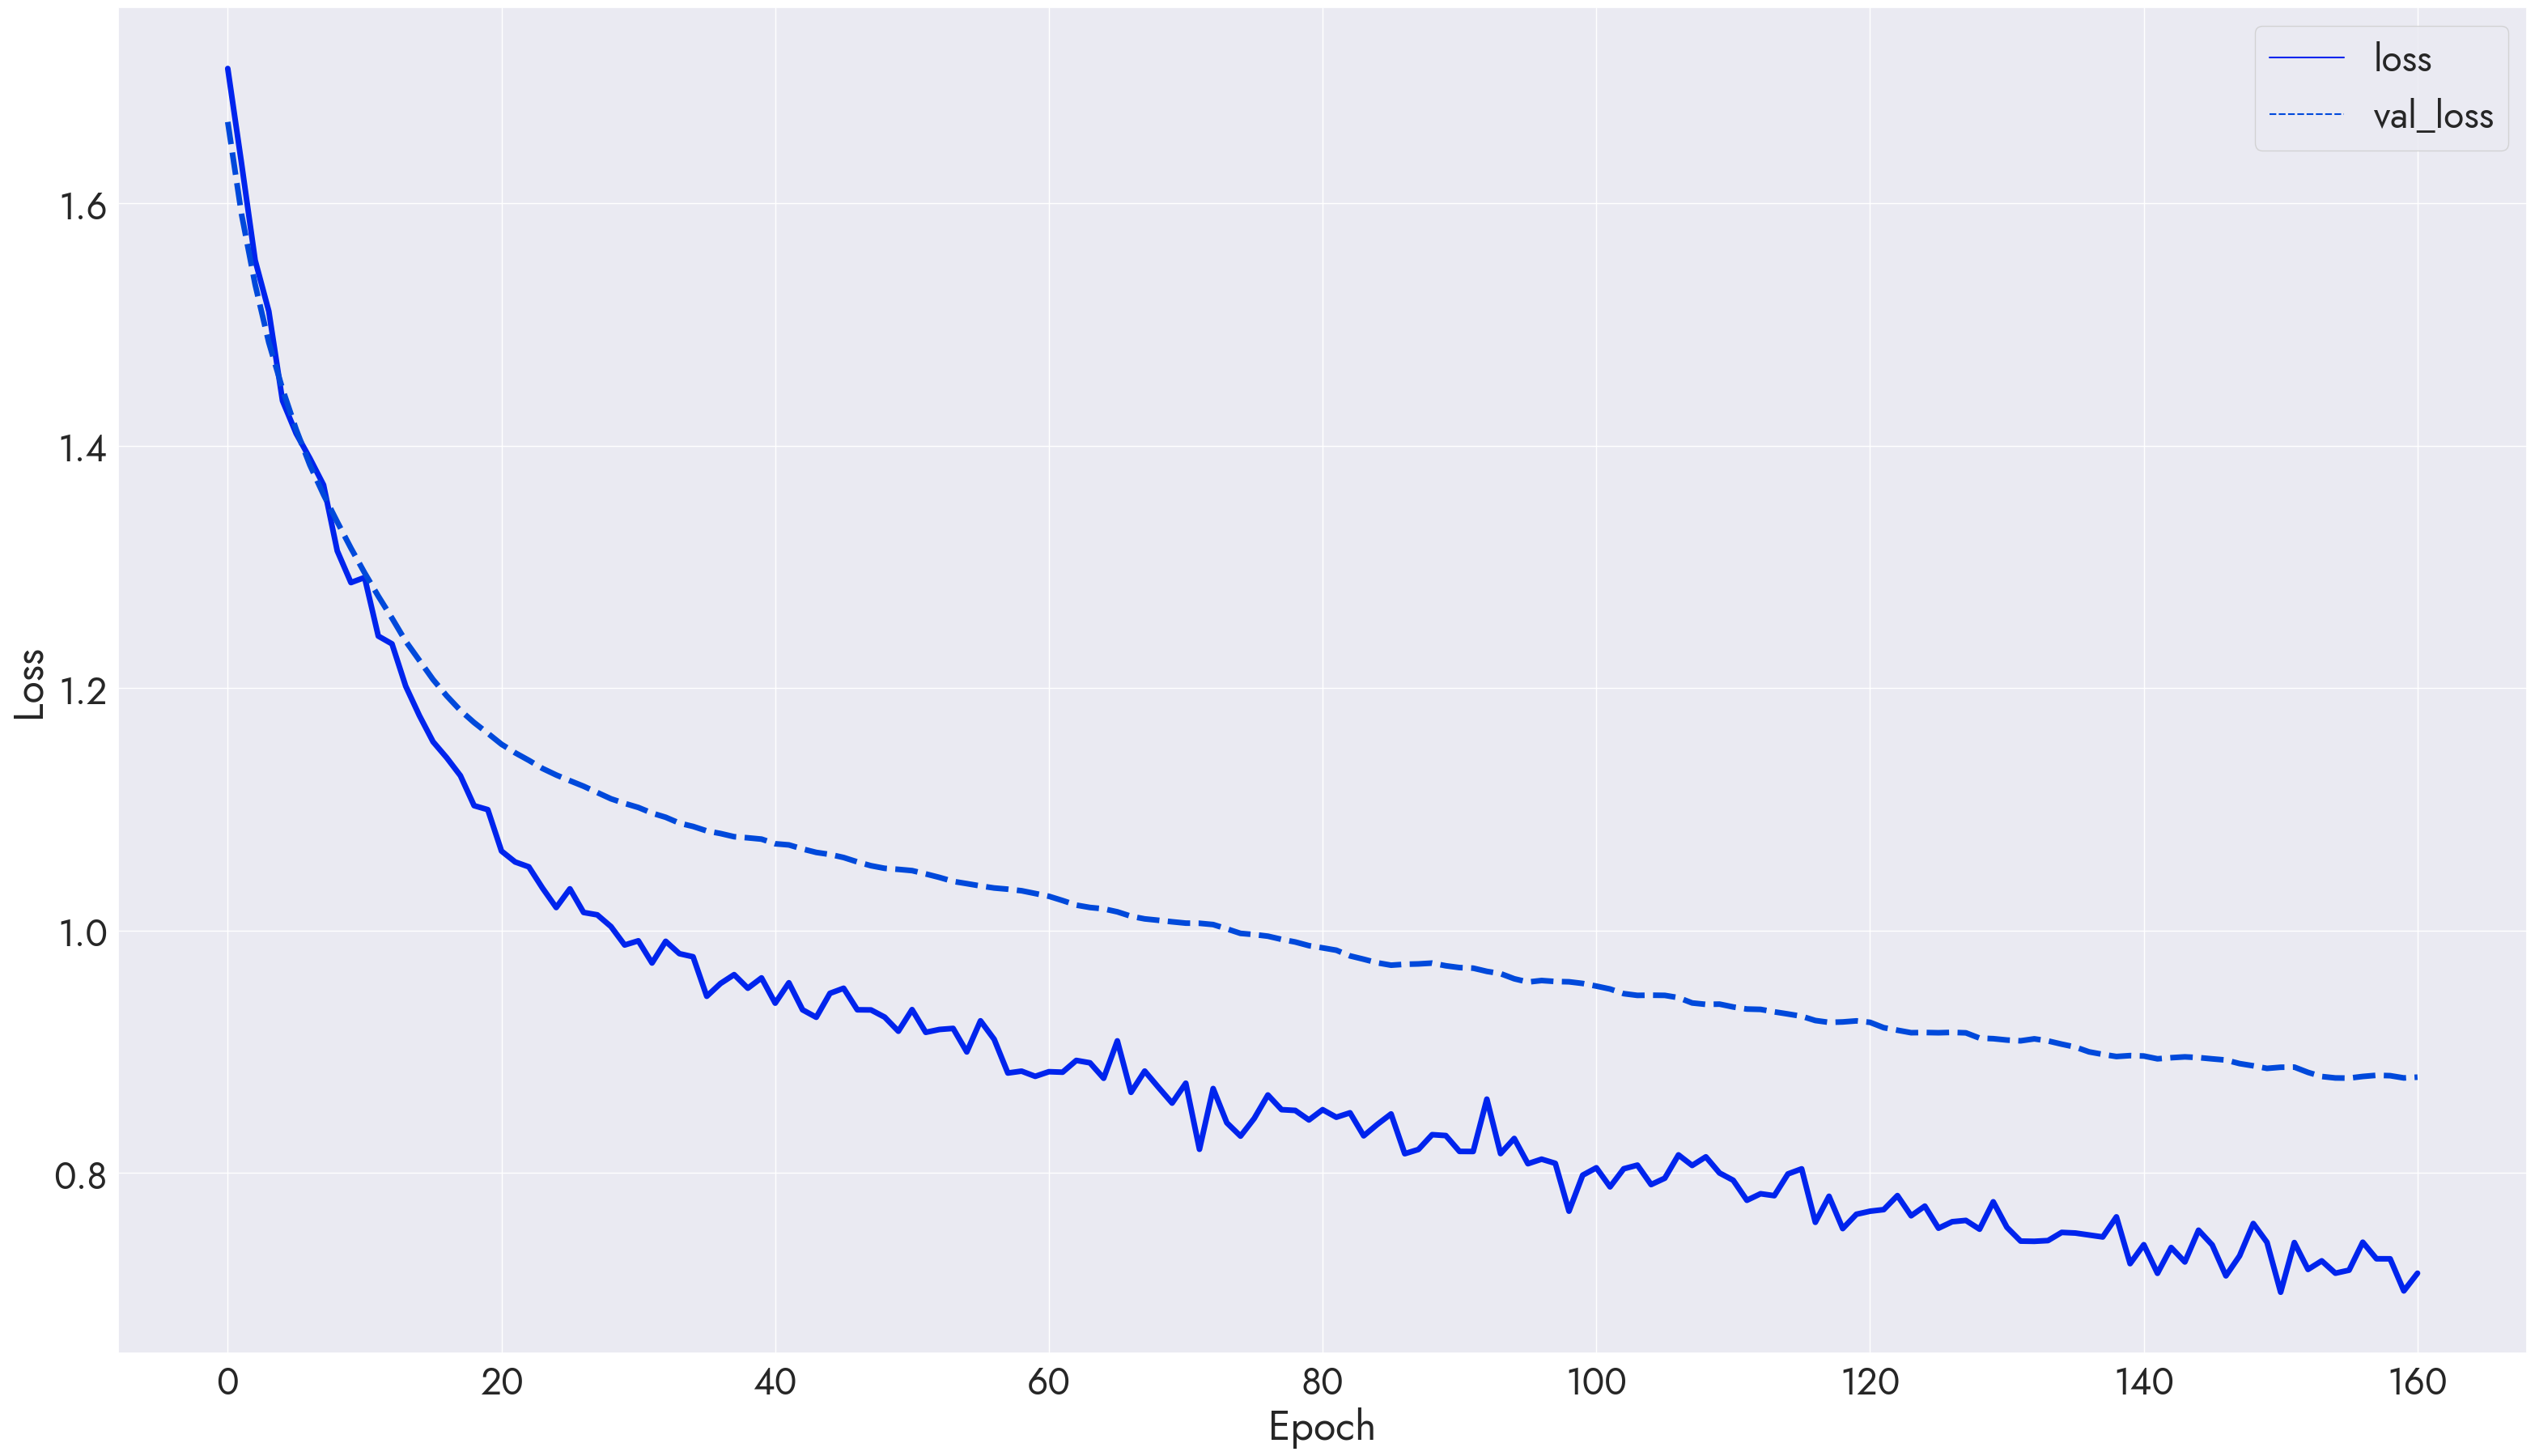

In [38]:
small_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['small'])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('Epoch')
small_plot_history.set_ylabel('Loss');

In [39]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{small_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [40]:
small_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

10/10 - 0s - loss: 0.6986 - accuracy: 0.7286 - 70ms/epoch - 7ms/step


In [41]:
small_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

3/3 - 0s - loss: 0.6985 - accuracy: 0.7039 - 39ms/epoch - 13ms/step


Сохраним модель:

In [42]:
small_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{small_model.name}')

2023-05-26 03:45:58.973164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-05-26 03:45:59.116864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed/fixed/fixed_small/assets


### medium
Обучим модель, состоящую из трёх обучающих слоёв.

In [43]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='medium'
)

In [44]:
size_histories['medium'] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                896       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,343
Trainable params: 5,316
Non-trainable params: 27
_________________________________________________________

Визуализируем ход обучения:

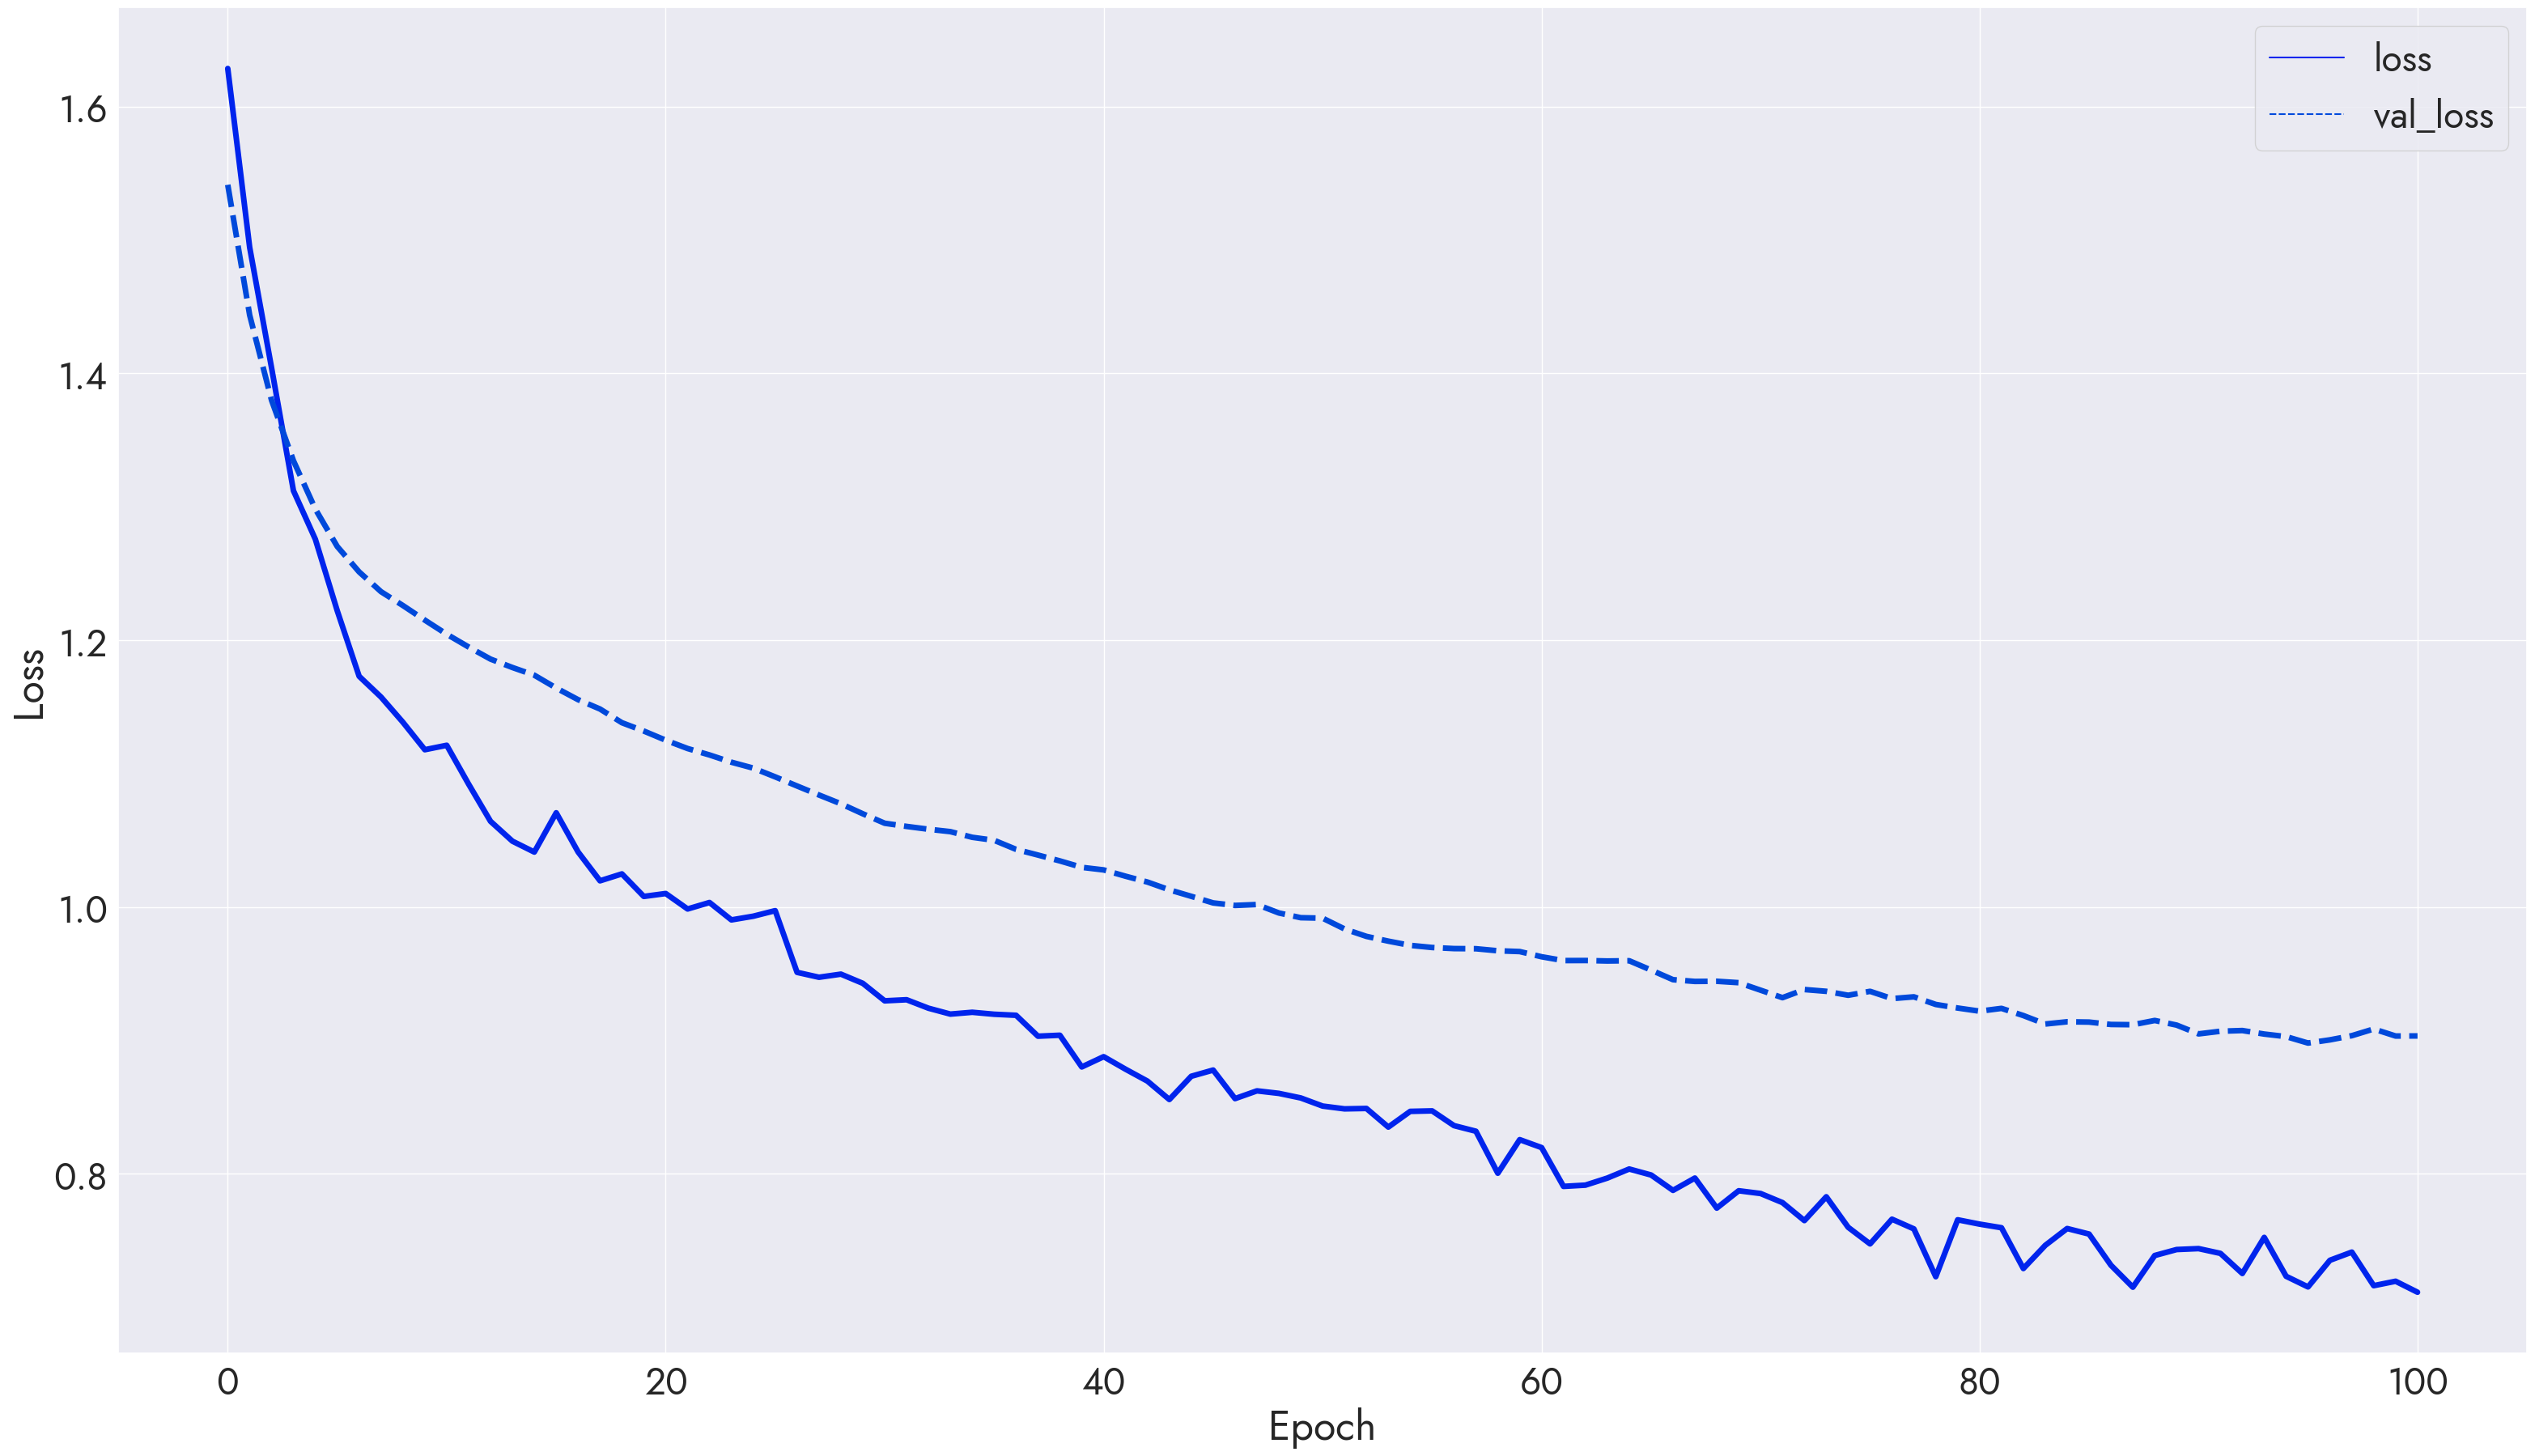

In [45]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['medium'])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('Epoch')
medium_plot_history.set_ylabel('Loss');

In [46]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{medium_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [47]:
medium_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

10/10 - 0s - loss: 0.7164 - accuracy: 0.7319 - 68ms/epoch - 7ms/step


In [48]:
medium_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

3/3 - 0s - loss: 0.6910 - accuracy: 0.7105 - 37ms/epoch - 12ms/step


Сохраним модель:

In [49]:
medium_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{medium_model.name}')

2023-05-26 03:46:30.481837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-26 03:46:30.642489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed/fixed/fixed_medium/assets


### large
Обучим модель, состоящую из шести обучающих слоёв.

In [50]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='large'
)

In [51]:
size_histories['large'] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 512)               7168      
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                             

Визуализируем ход обучения:

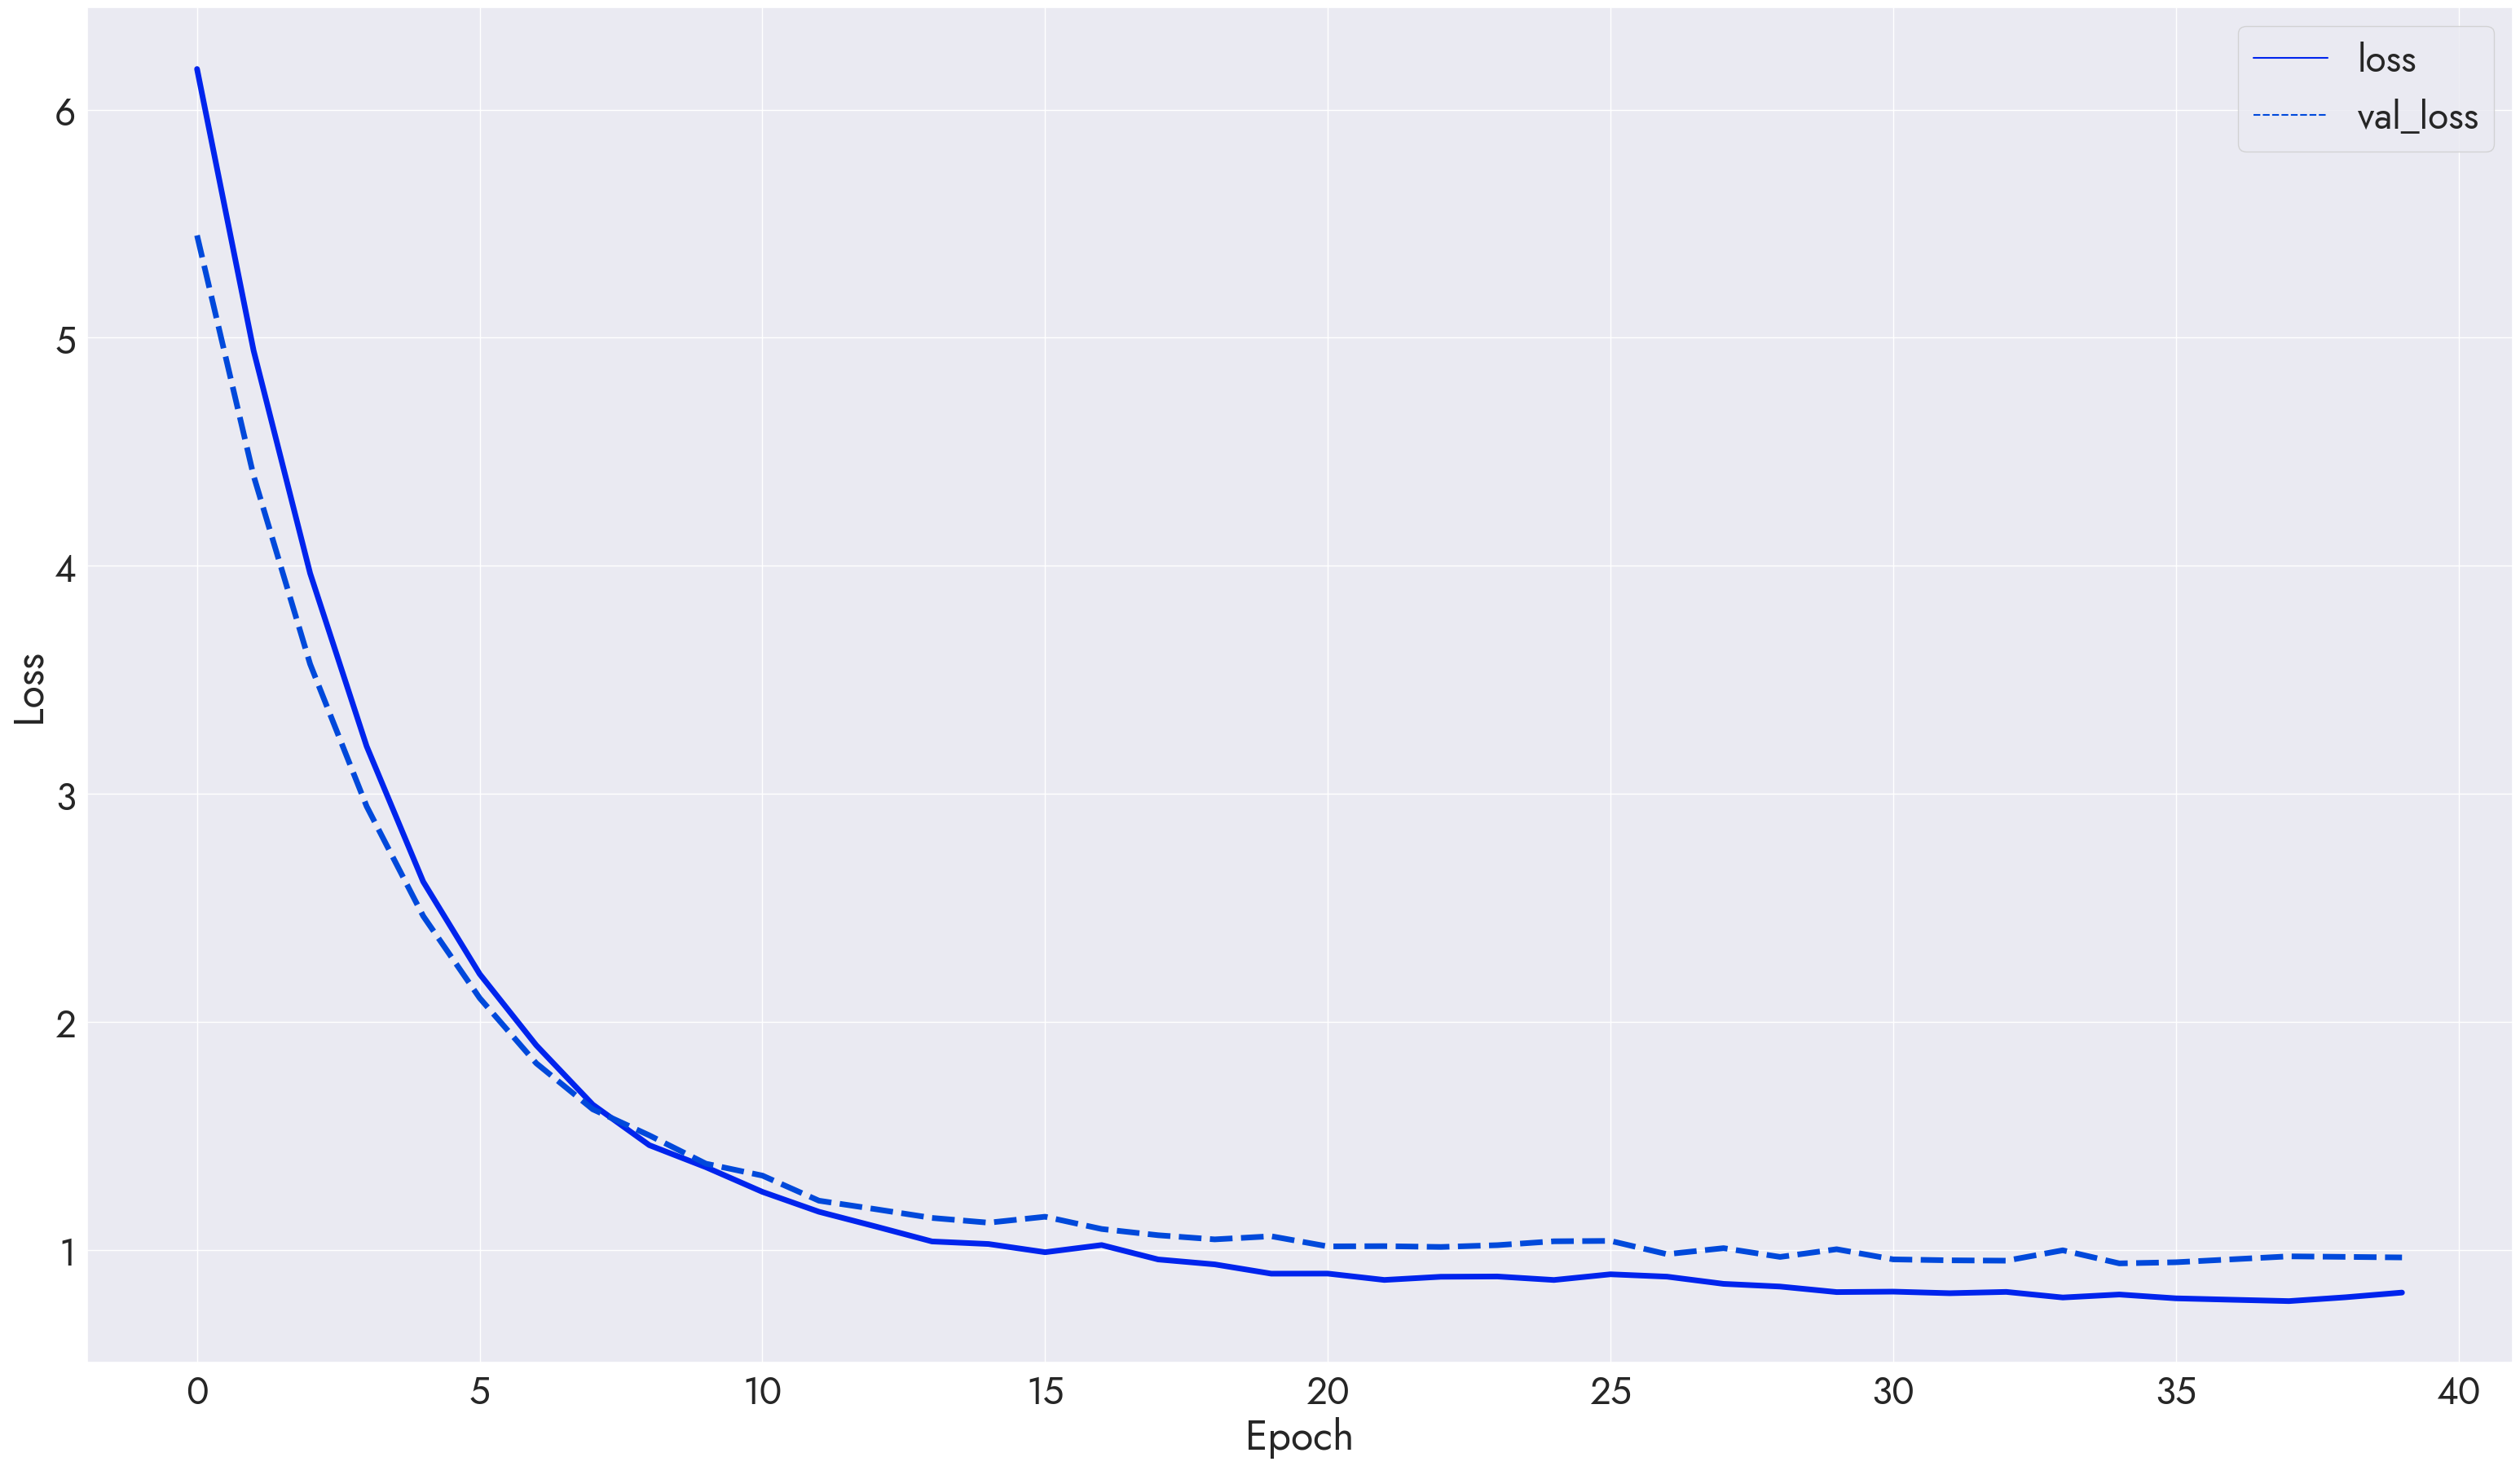

In [52]:
large_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['large'])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('Epoch')
large_plot_history.set_ylabel('Loss');

In [53]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{large_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [54]:
large_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

10/10 - 0s - loss: 0.7978 - accuracy: 0.7352 - 79ms/epoch - 8ms/step


In [55]:
large_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

3/3 - 0s - loss: 0.7713 - accuracy: 0.7105 - 40ms/epoch - 13ms/step


Сохраним модель:

In [56]:
medium_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{large_model.name}')

2023-05-26 03:46:54.751976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-26 03:46:54.956998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed/fixed/fixed_large/assets


### finally
Выберем лучшую модель и проанализируем её предсказательные возможности.

Визуализируем график изменения точности предсказаний полученных моделей:

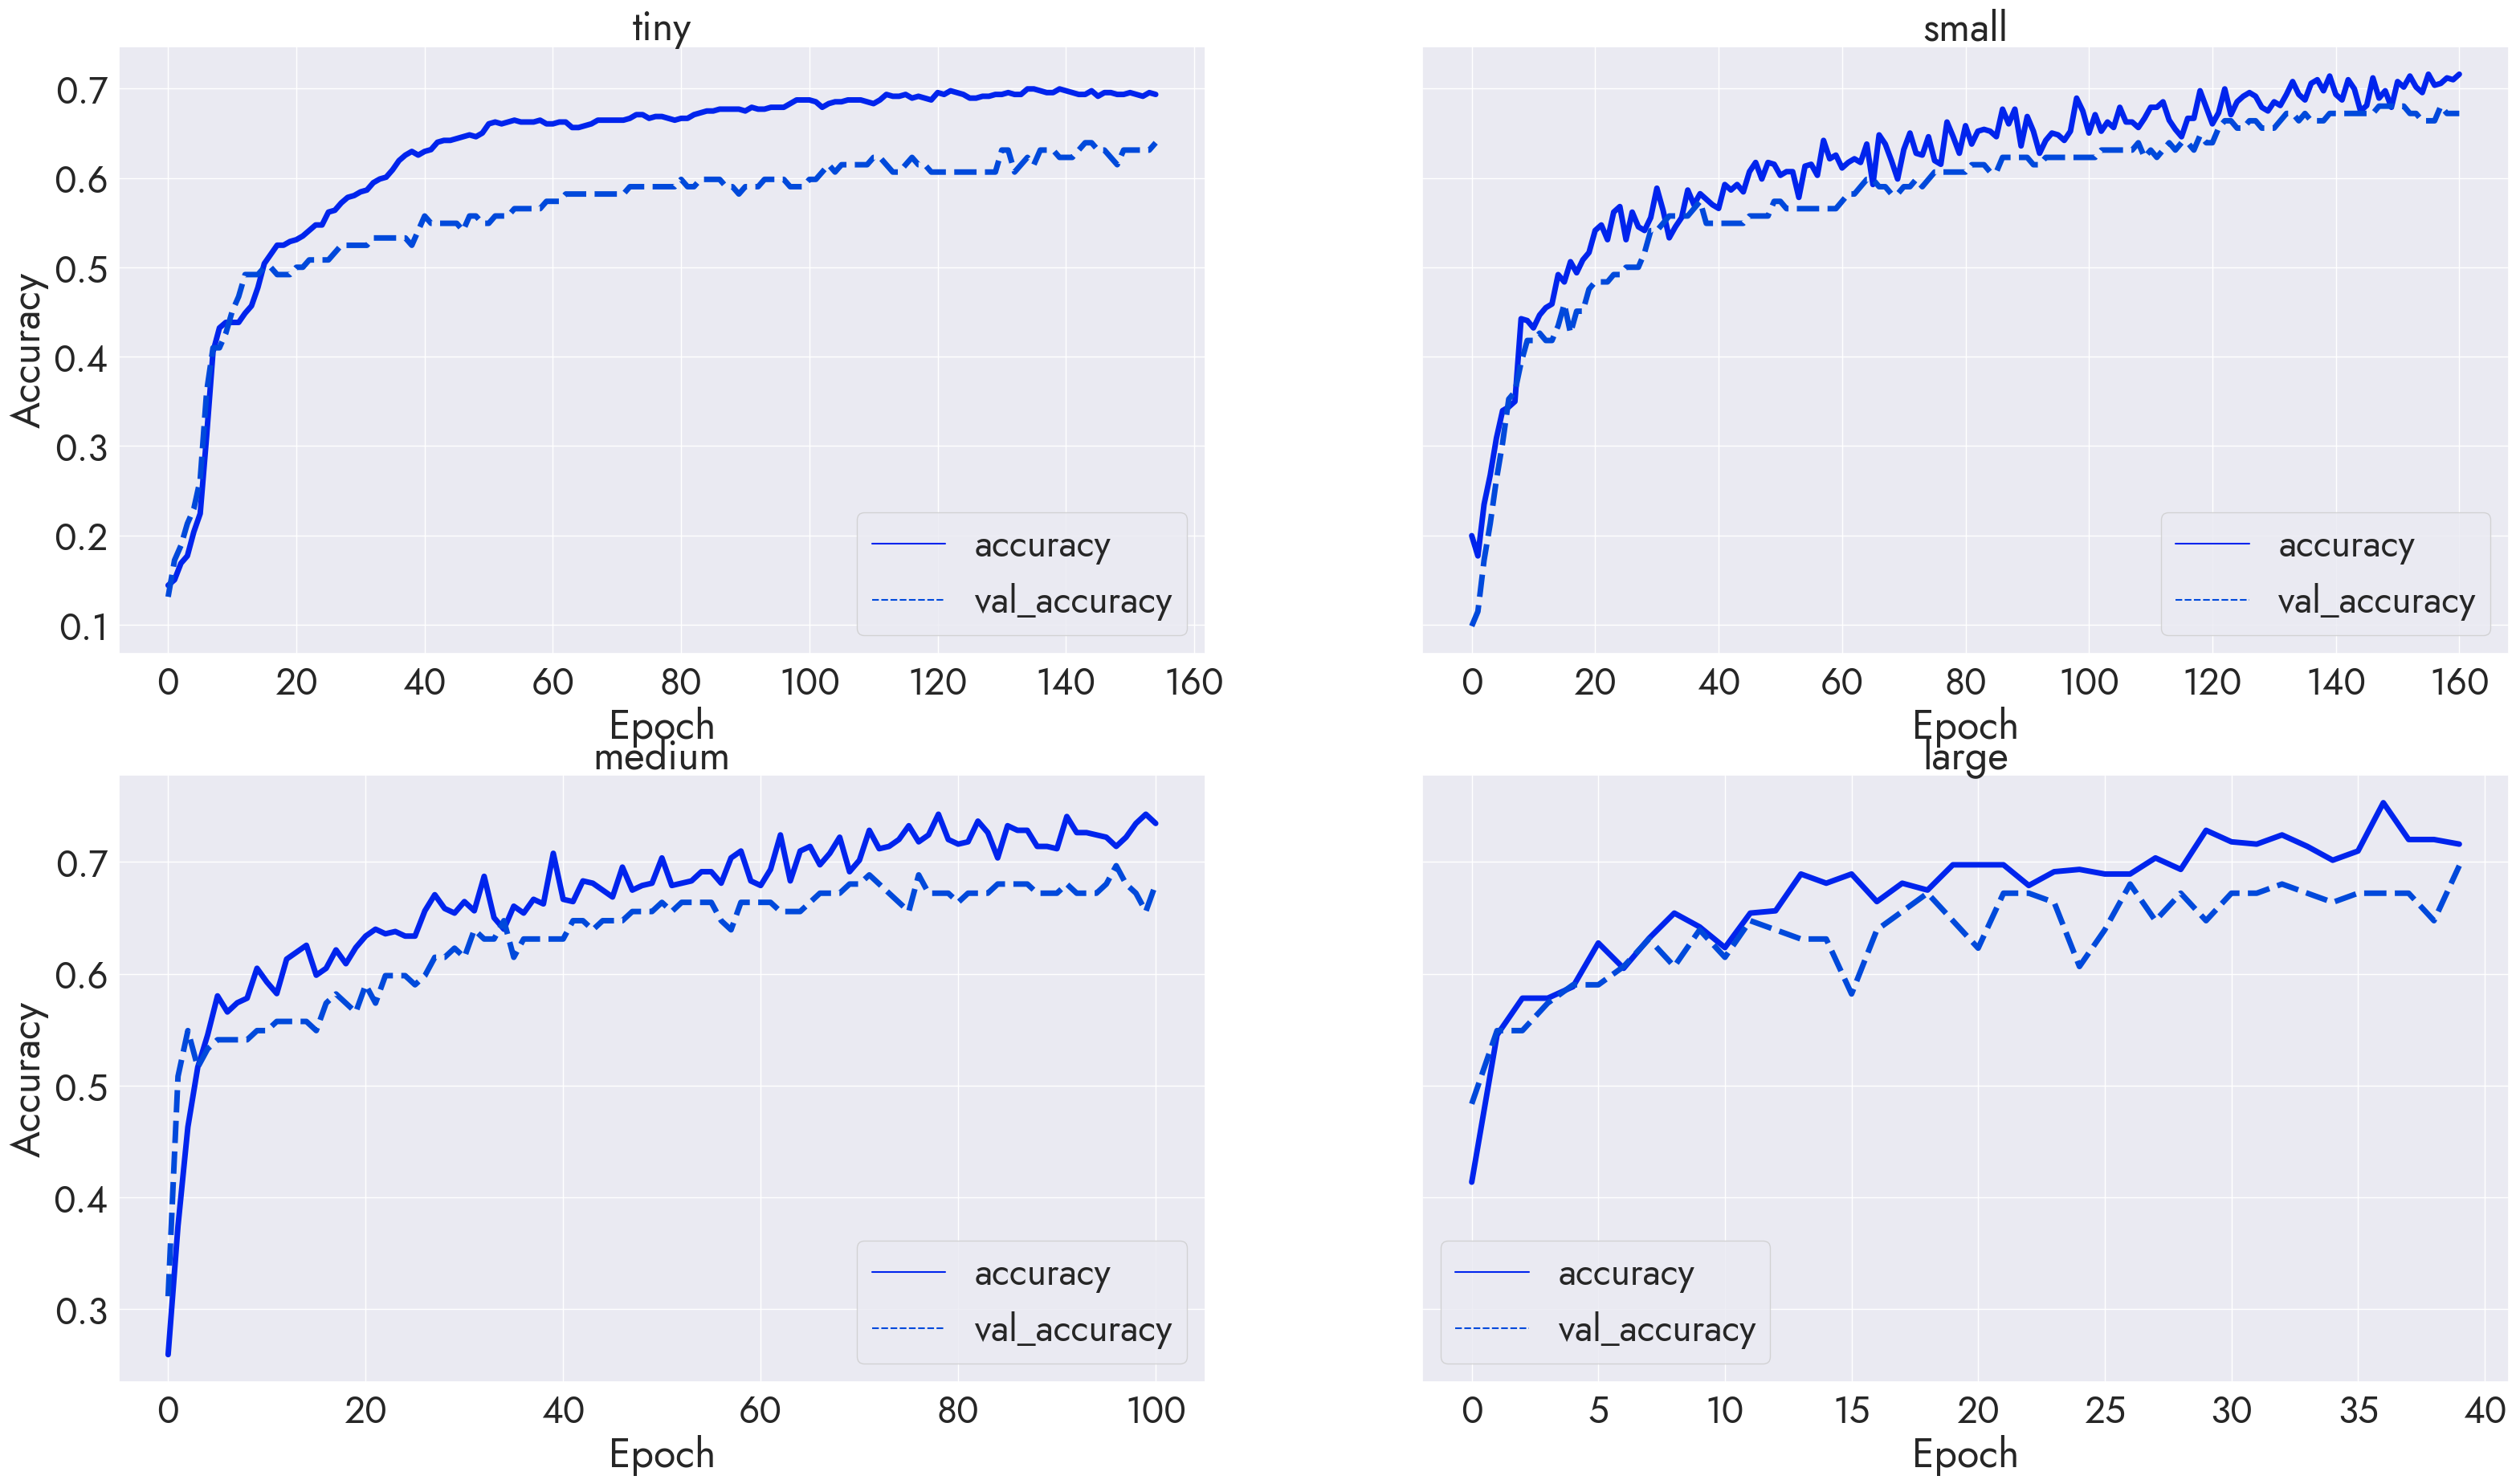

In [57]:
fig, axs = plt.subplots(2, 2, sharey='row')

for history_name, ax in zip(size_histories, axs.flat):
    sns.lineplot(data=pd.DataFrame(size_histories[history_name])[['accuracy', 'val_accuracy']], linewidth=5, ax=ax)

    ax.set_title(history_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')

In [58]:
fig.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history.png', transparent=True)

Выберем в качестве основной модель с наибольшей точностью предсказаний:

In [59]:
df_model = large_model

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [60]:
test_predict = df_model.predict(test_features, batch_size=BATCH_SIZE, verbose=2);

3/3 - 0s - 89ms/epoch - 30ms/step


Массив предсказанных значений состоит из весов, с каким шансом к какой группе относится конкретное наблюдение.
Конвертируем его в вид dummy-переменных:

In [61]:
test_predict = np.where(test_predict == test_predict.max(axis=1).reshape(-1, 1), 1, 0).astype('int8')

Рассмотрим распределение предсказаний модели по группам:

In [62]:
df_dist = pd.pivot_table(
        data=pd.concat(
            [
                pd.from_dummies(pd.DataFrame(test_target)).rename(columns={'': 'target'}),
                pd.DataFrame(test_predict),
            ],
            axis=1
        ),
        columns='target',
        aggfunc='sum',
    )

df_dist.rename(
    index=dict(zip(range(4), groups)),
    columns=dict(zip(range(4), groups)),
    inplace=True,
)

df_dist

target,Low income,Lower-middle income,Upper-middle income,High income
Low income,32,12,2,0
Lower-middle income,6,18,12,3
Upper-middle income,0,3,26,4
High income,0,0,2,32


Выведем данную таблицу на тепловую карту:

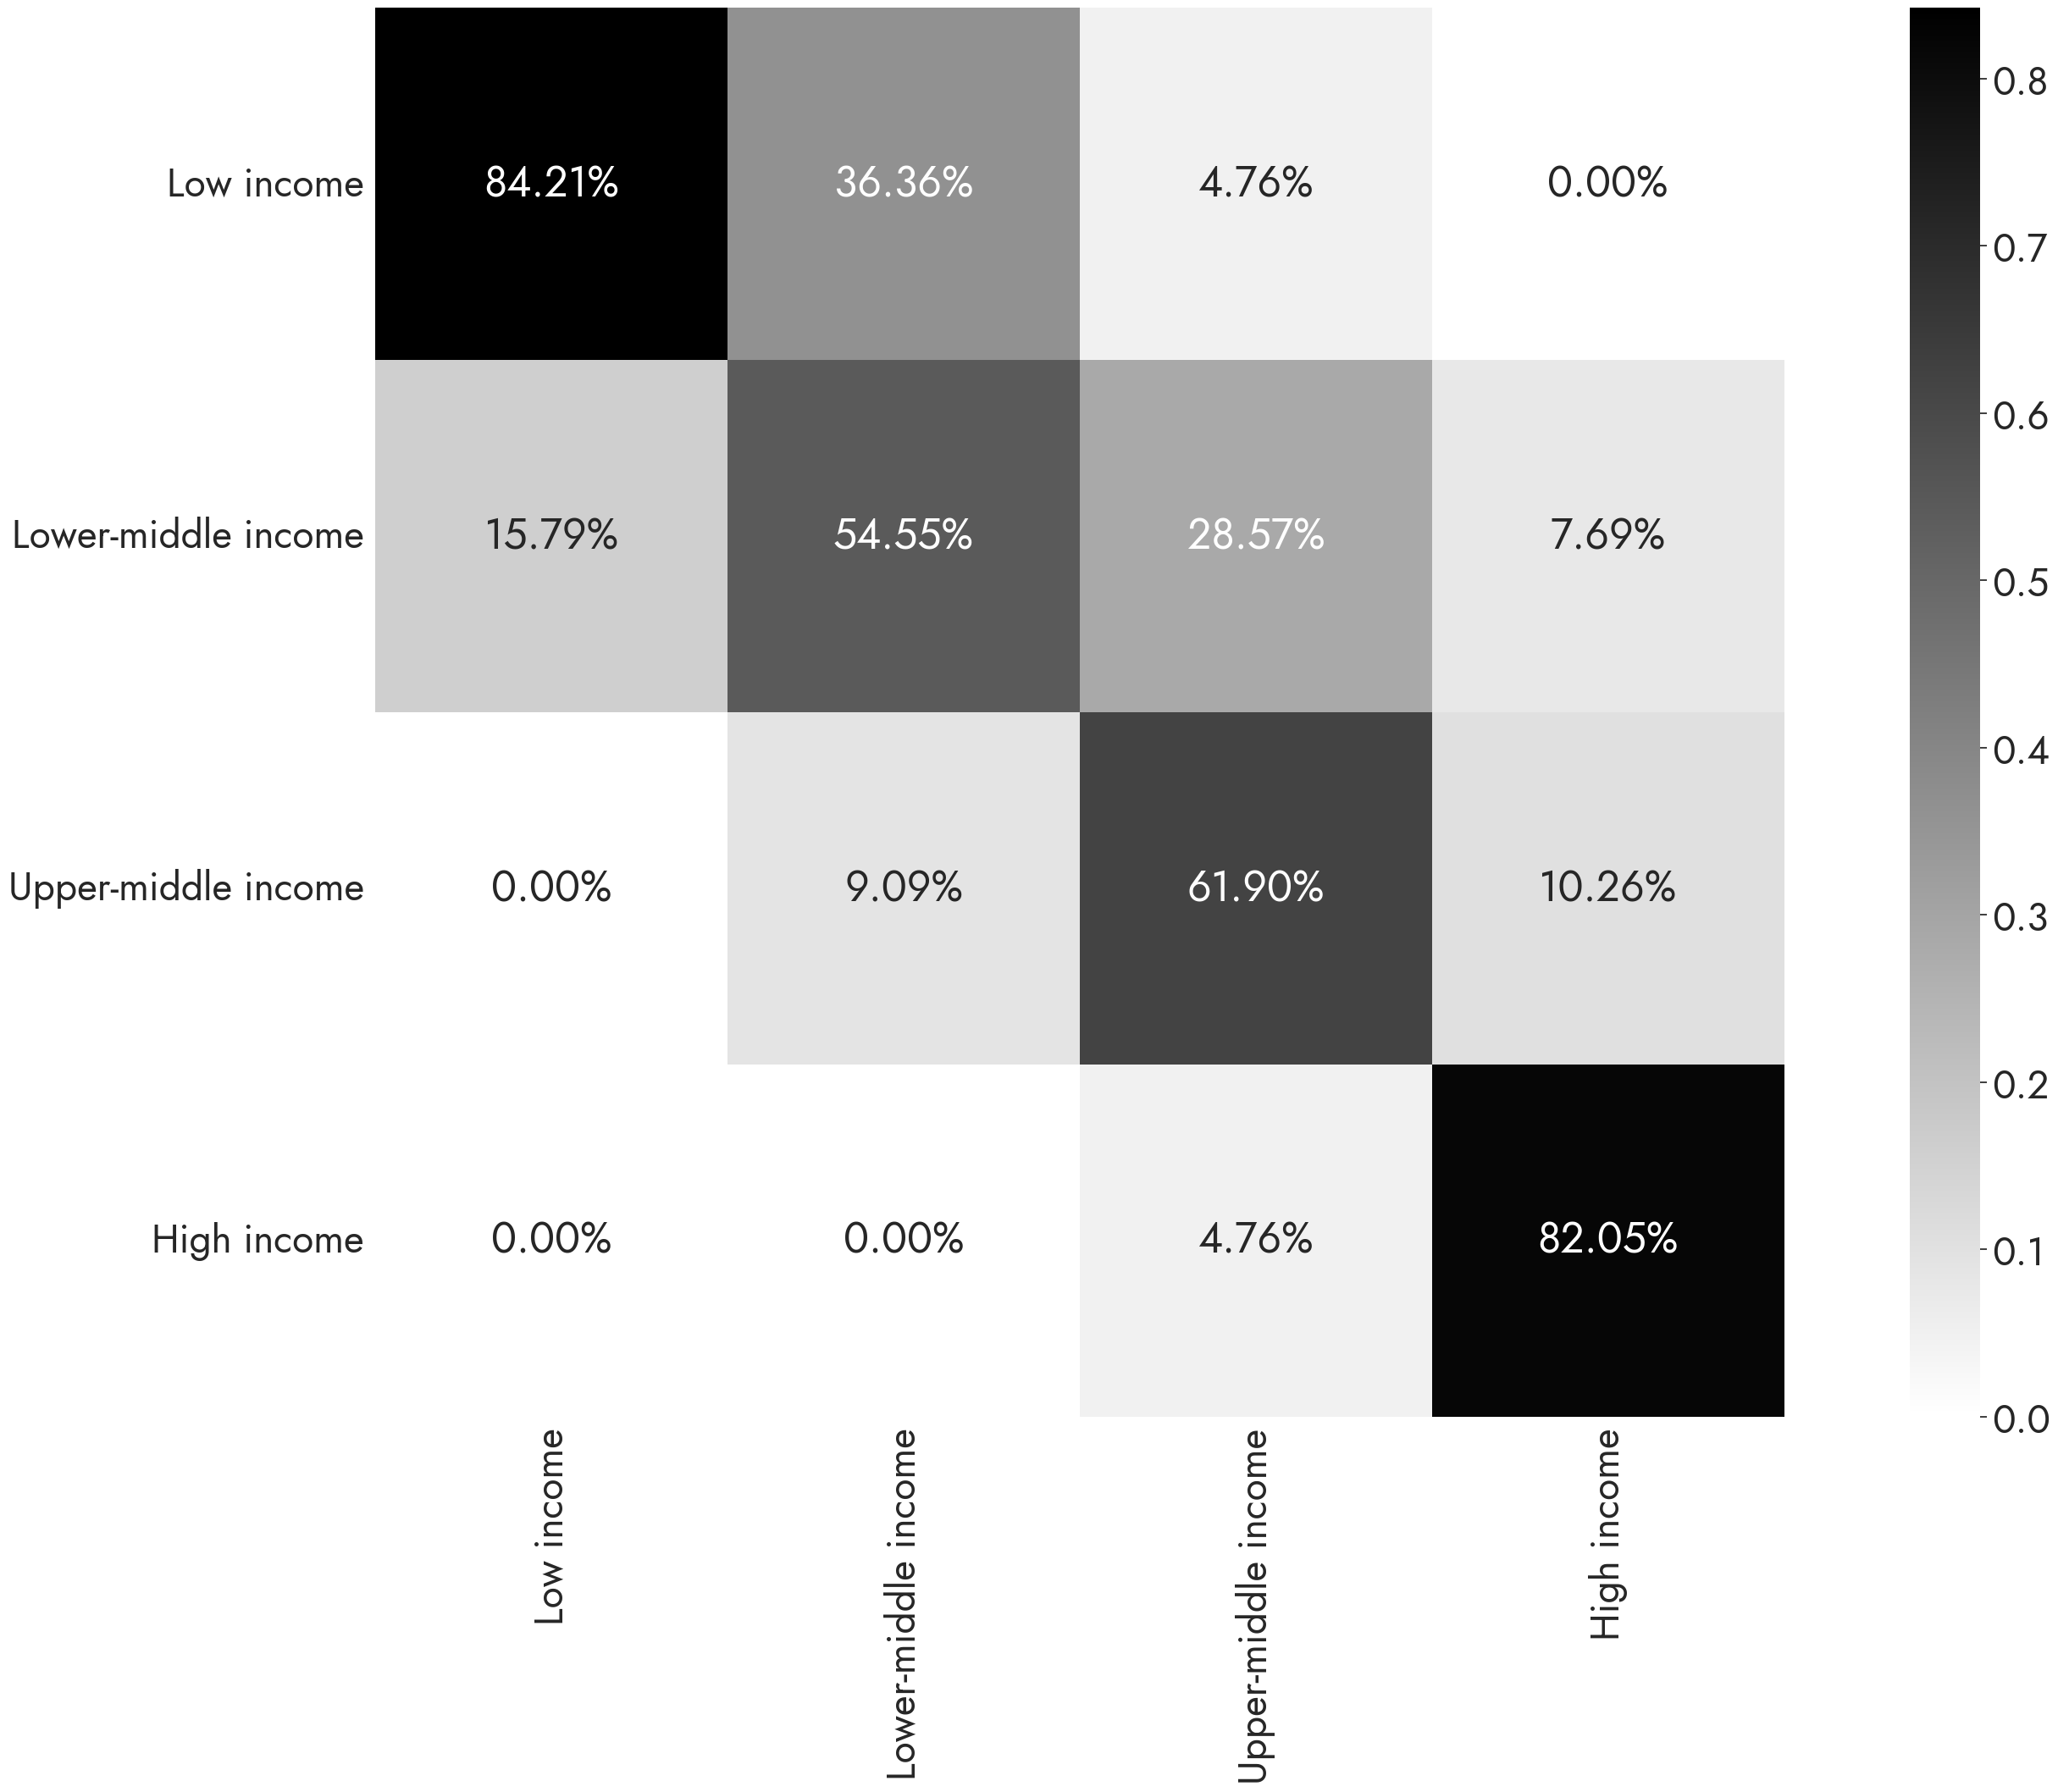

In [63]:
df_plot_dist = sns.heatmap(df_dist / df_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

df_plot_dist.set_xlabel(None);

In [64]:
df_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist.png', transparent=True)

Как видно по сводной таблице и по графику, в большинстве случаев модель верно определяет группу.
Визуализируем распределение ошибок в модели:

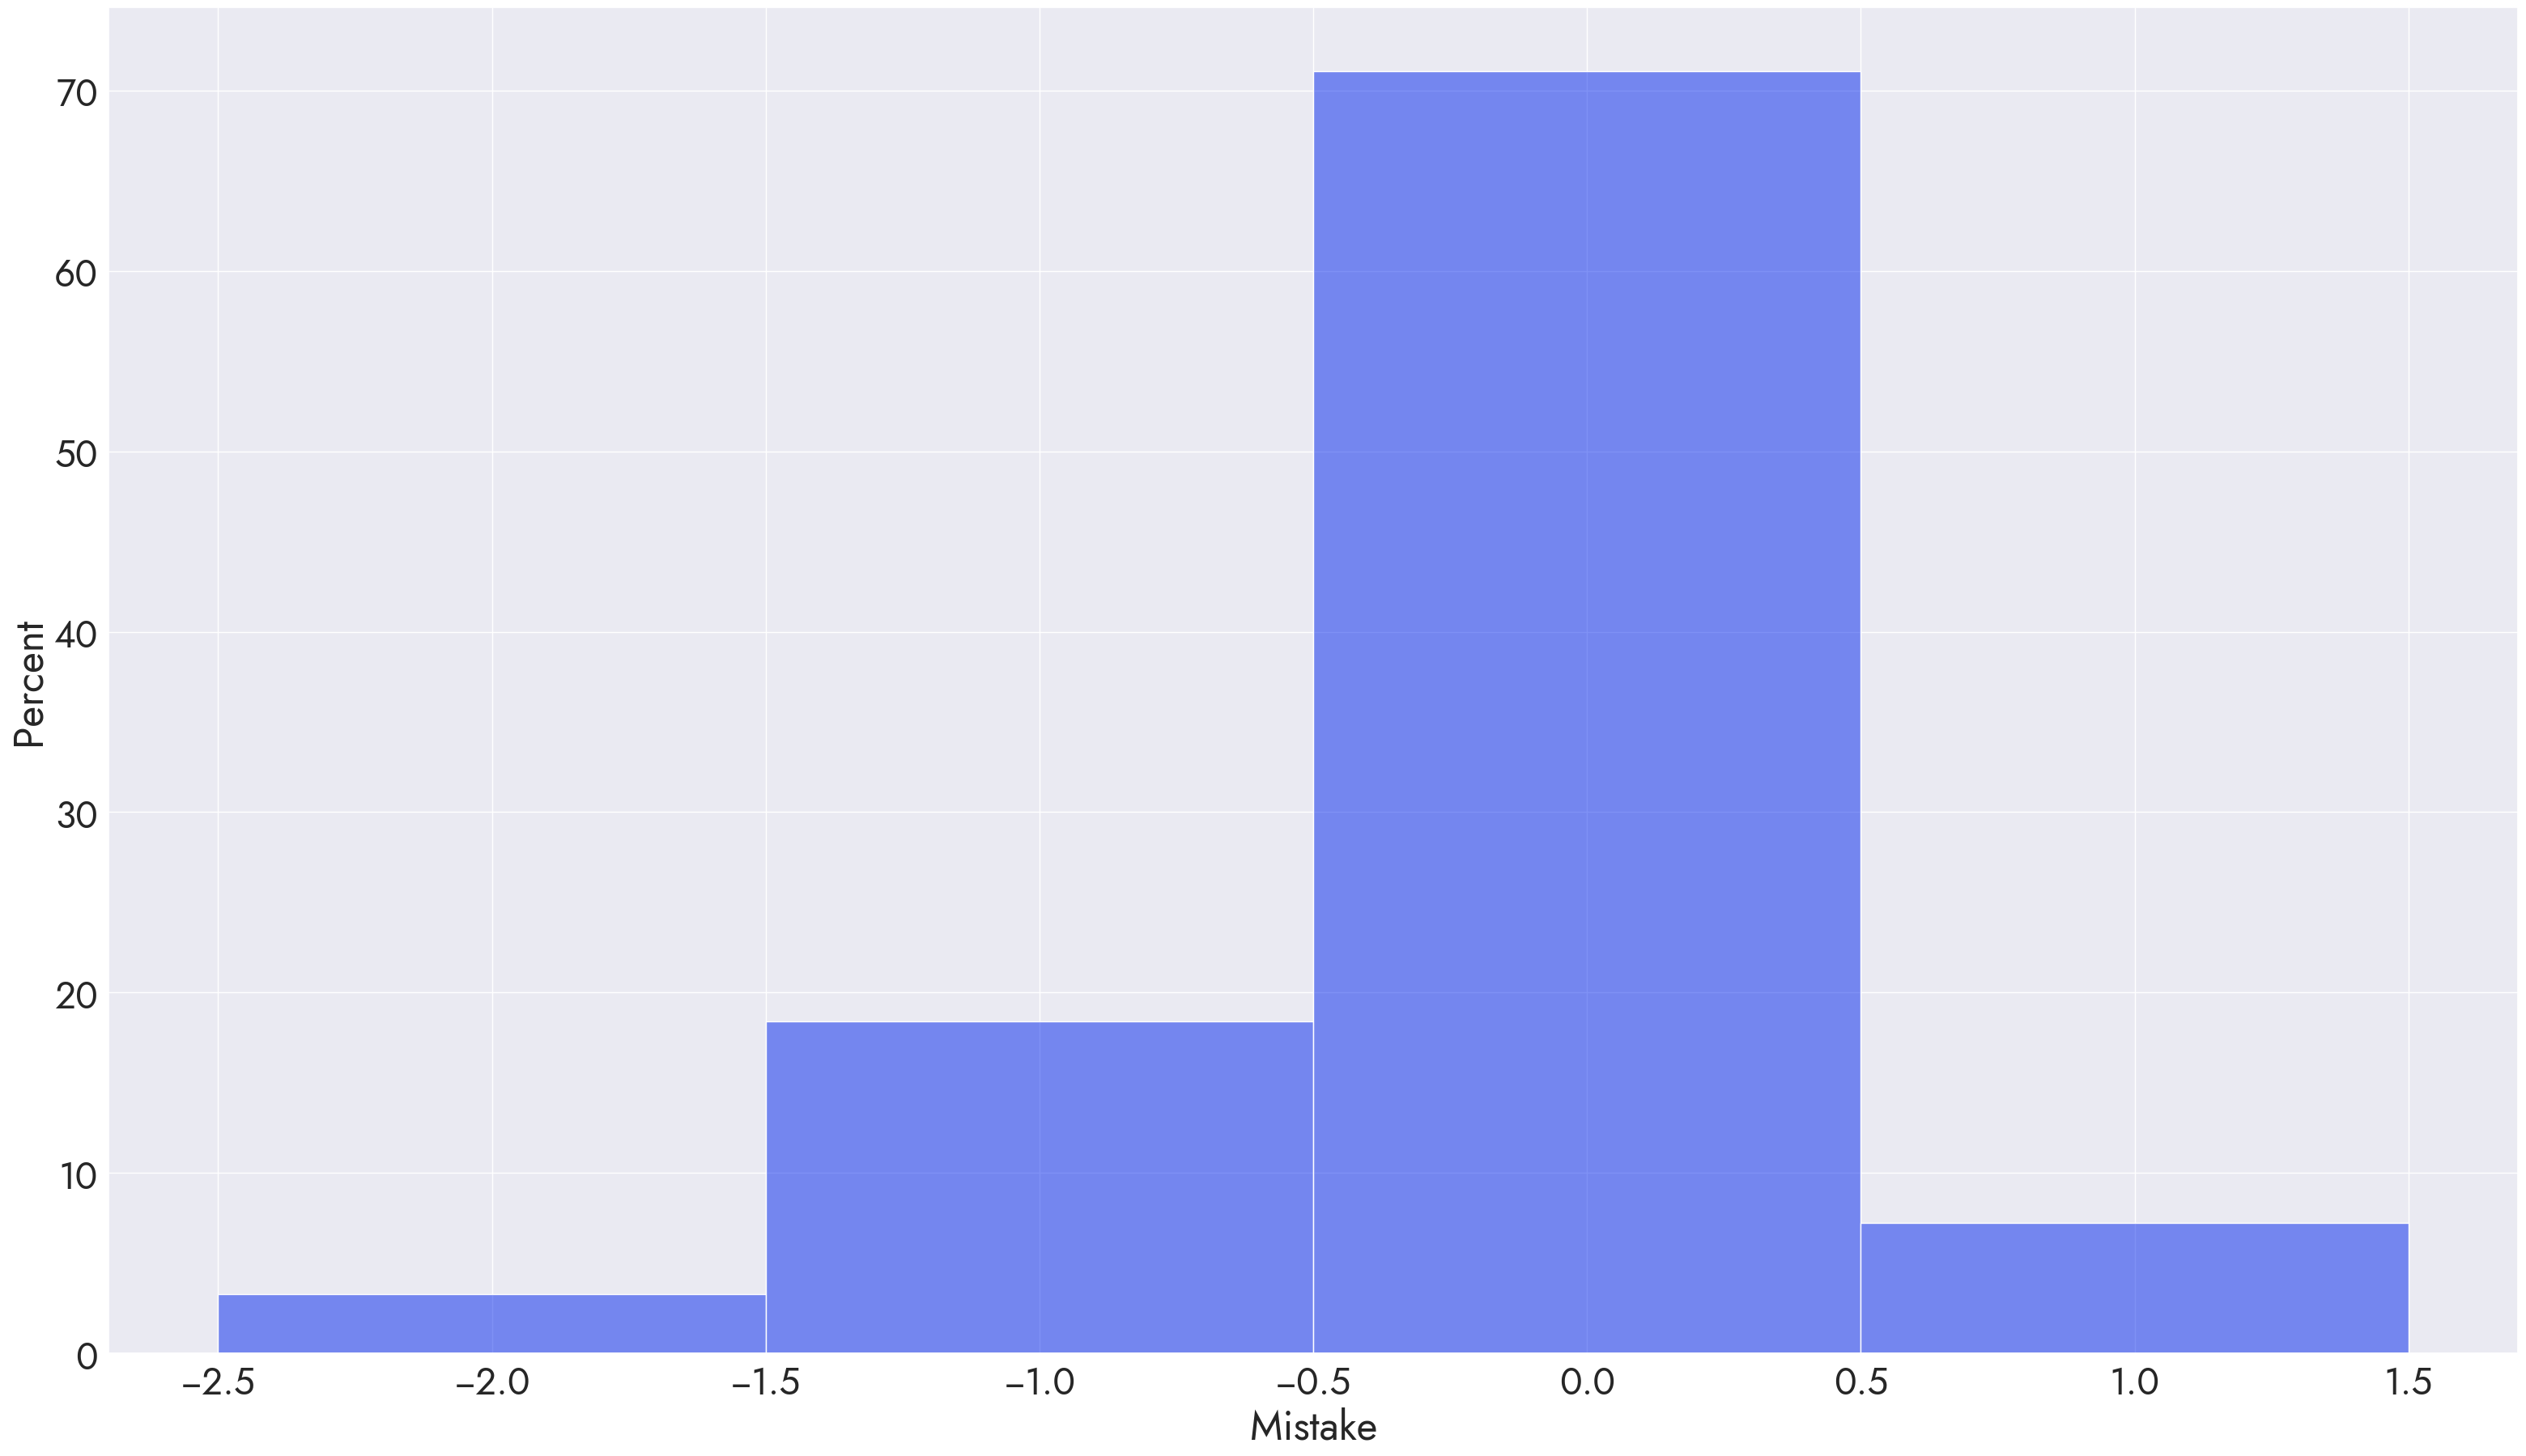

In [65]:
df_plot_mistakes = sns.histplot(data=pd.from_dummies(pd.DataFrame(test_predict)) - pd.from_dummies(pd.DataFrame(test_target)),
                                stat='percent', legend=False, discrete=True)

df_plot_mistakes.set_xlabel('Mistake');

In [66]:
df_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.